In [140]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
from matplotlib.dates import date2num, num2date
from utide import solve, reconstruct
import numpy as np
import pandas as pd
from windrose import WindroseAxes
import scipy as sp
import hvplot.xarray
from eofs.xarray import Eof
import glob
import sklearn as skl
from sklearn.utils.extmath import randomized_svd
#import dask
from matplotlib import style
import EOF_funcs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
import GA_cofine
from  importlib  import reload

Reading the data, if surface.nc exists, read it, if not read the subset, select surface layer and replace NaN with interpolation in time. 

In [141]:
filenm='Data/surface_.nc'
try:
    print('Read:'+filenm)
    surface=xr.open_dataset(filenm)
except:
    print('Cannot find:'+filenm)
    print('Creating...')
    data=xr.open_dataset('byfjordenSubset.nc')
    data.close()
    surface=data.isel(depth=0).sel(Y=slice(6733400,6737500),X=slice(-40000,-35000)).isel(depth=0)
    surface['u']=surface.u.interpolate_na(dim='time')
    surface['v']=surface.v.interpolate_na(dim='time')
    surface.to_netcdf(filenm)



Read:Data/surface_.nc


Text(0.5, 1.0, 'Standard deviation v velocity')

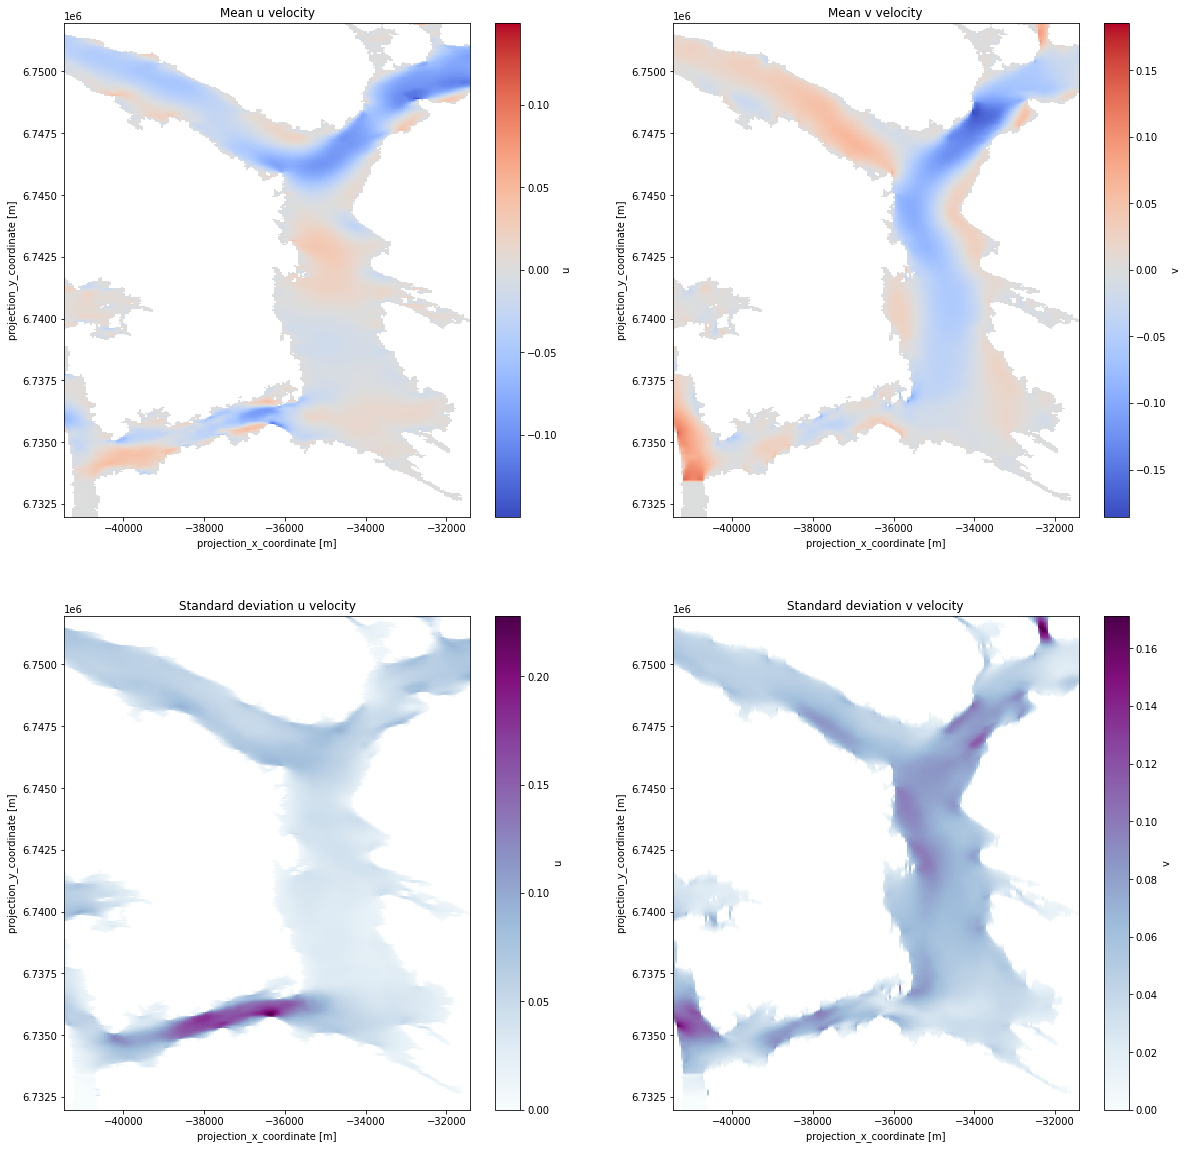

In [142]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
cmap='coolwarm'
cmap_std='BuPu'
surface.u.mean(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[0,0],cmap=cmap)
axes[0,0].set_title('Mean u velocity')
surface.v.mean(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[0,1],cmap=cmap)
axes[0,1].set_title('Mean v velocity')
surface.u.std(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[1,0],cmap=cmap_std)
axes[1,0].set_title('Standard deviation u velocity')
surface.v.std(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[1,1],cmap=cmap_std)
axes[1,1].set_title('Standard deviation v velocity')


In [143]:
surface=surface.sel(Y=slice(6733400,6737500),X=slice(-40000,-35000))

Text(0.5, 1.0, 'Standard deviation v velocity')

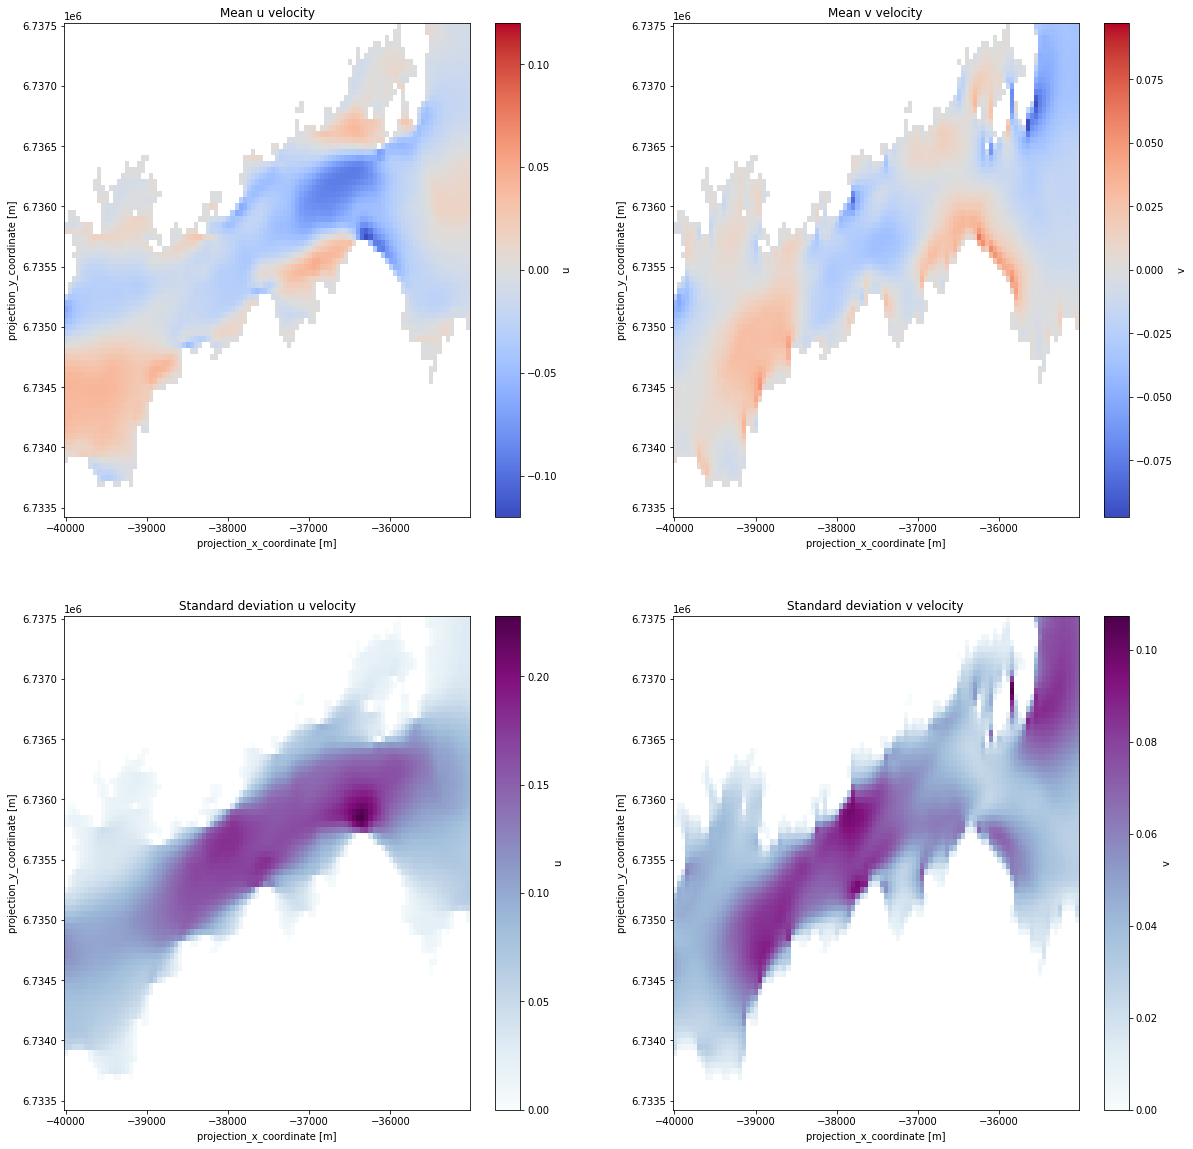

In [144]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
cmap='coolwarm'
cmap_std='BuPu'
surface.u.mean(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[0,0],cmap=cmap)
axes[0,0].set_title('Mean u velocity')
surface.v.mean(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[0,1],cmap=cmap)
axes[0,1].set_title('Mean v velocity')
surface.u.std(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[1,0],cmap=cmap_std)
axes[1,0].set_title('Standard deviation u velocity')
surface.v.std(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[1,1],cmap=cmap_std)
axes[1,1].set_title('Standard deviation v velocity')


Text(0.5, 1.0, 'Correlation u and v')

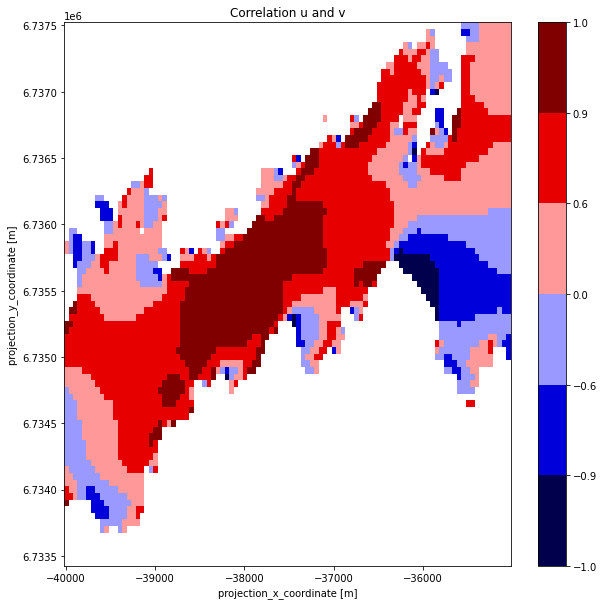

In [145]:
fig, axes = plt.subplots(ncols=1, figsize=(10,10))
xr.corr(surface.u,surface.v,dim='time').plot(vmin=-1,vmax=1,levels=[-1,-0.9,-0.6,0,0.6,0.9,1],cmap='seismic',ax=axes)
axes.set_title('Correlation u and v')


In [202]:
reload(GA_cofine)
tmp=GA_cofine.GA_cofine(surface,tresh=0.8)#,vel_names=['u'])

doing SVD analysis


In [203]:
tmp.data.sizes['time']

1501

In [204]:
A=tmp.calc_PCS(tmp.data.norm)
B=tmp.calc_PCS(tmp.coarse.norm)


In [159]:
Aest=tmp.est_PCS(tmp.coarse.U)

<xarray.DataArray (mode: 9)>
array([1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)
Coordinates:
    depth    float32 1.0
Dimensions without coordinates: mode


In [208]:
An=A/A.std(axis=0)
Bn=B/B.std(axis=0)


In [237]:
Uc,Lc,Vtc=np.linalg.svd(tmp.coarse.norm.data.T)

Uf,Lf,Vtf=np.linalg.svd(tmp.data.norm.data.T)

In [240]:
Vf=Vtf.T
Vc=Vtc.T

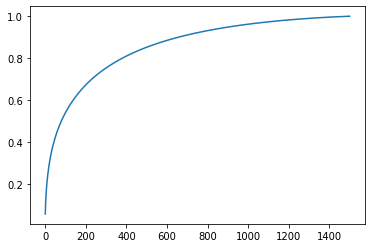

In [238]:
plt.plot(Lf.cumsum()/Lf.sum())

In [244]:
Vnf=(Vf-Vf.mean(axis=0))/Vf.std(axis=0)
Vcf=(Vc-Vc.mean(axis=0))/Vc.std(axis=0)

In [247]:
np.shape(Vcf)

(1501, 1501)

In [106]:
vel=xr.DataArray(Aest.data@tmp.U.data.T,dims=['time','z'],coords=tmp.data.coords)
vel

<xarray.DataArray (time: 1501, z: 6990)>
array([[-0.3066868 , -0.12447598, -0.8683549 , ...,  1.1825763 ,
         1.1926814 ,  1.2236357 ],
       [ 0.20108956,  0.3722089 , -0.32922885, ...,  0.8525778 ,
         0.9556113 ,  1.0472733 ],
       [ 0.5303744 ,  0.5341951 , -0.14528295, ..., -0.18768722,
        -0.02462453,  0.15221183],
       ...,
       [ 2.566426  ,  2.3541455 ,  1.4027592 , ..., -3.9260716 ,
        -3.5291705 , -3.139925  ],
       [ 1.9482912 ,  1.9910601 ,  1.2632192 , ..., -3.8657708 ,
        -3.7437866 , -3.604712  ],
       [ 0.39631316,  0.7702422 ,  0.0423289 , ..., -3.260136  ,
        -3.366608  , -3.4581711 ]], dtype=float32)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
  * z        (z) MultiIndex
  - comp     (z) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
  - Y        (z) float64 6.734e+06 6.734e+06 6.734e+06 ... 6.737e+06 6.737e+06
  - X        (z) float64 -3.959e+04 -3.954e+04 ... -3.509e+04 -3.504e+04

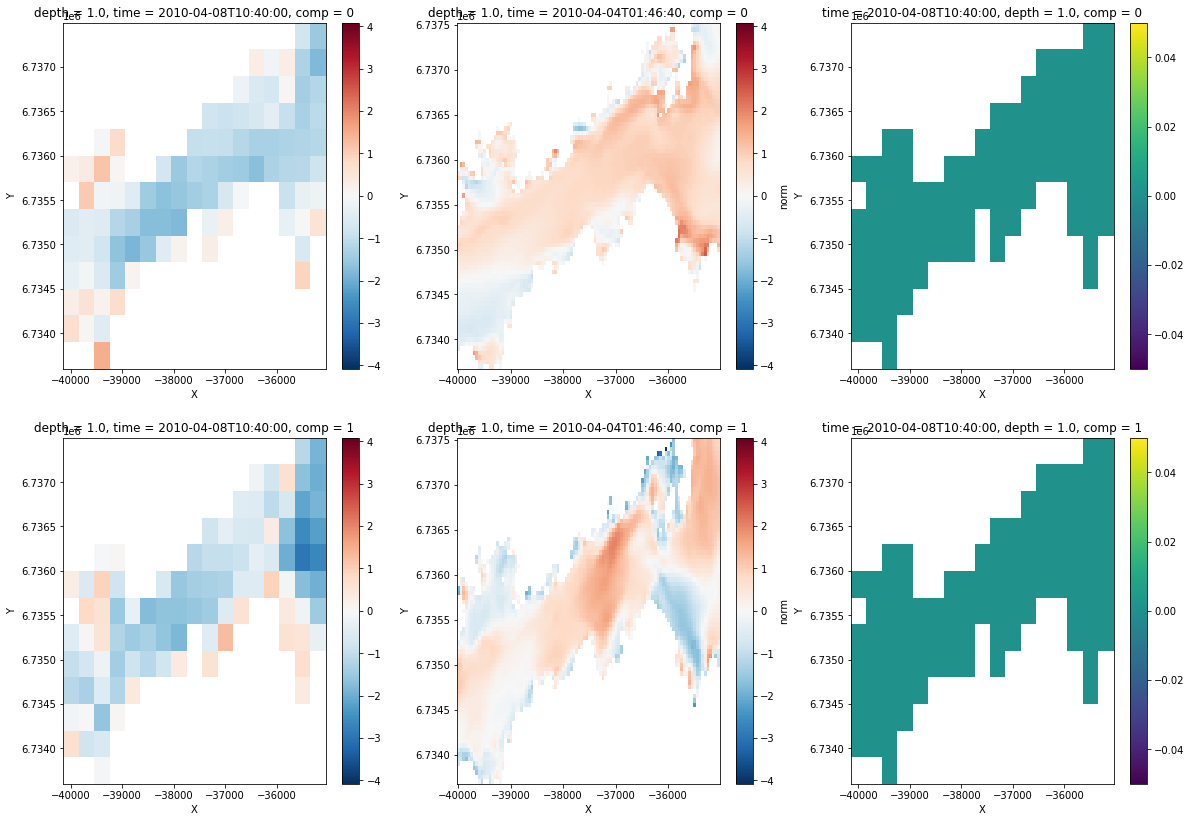

In [187]:
time=100
vmin=tmp.data.norm.isel(time=time).min()
vmax=tmp.data.norm.isel(time=time).max()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,14))
for ii in np.arange(2):
    vel.unstack('z').isel(comp=ii,time=time).plot(vmin=vmin,ax=axes[ii,0])
    tmp.data.norm.unstack('z').isel(comp=ii,time=time).plot(vmin=vmin,ax=axes[ii,1])
    (tmp.data.norm-vel).unstack('z').isel(comp=ii,time=time).plot(ax=axes[ii,2])

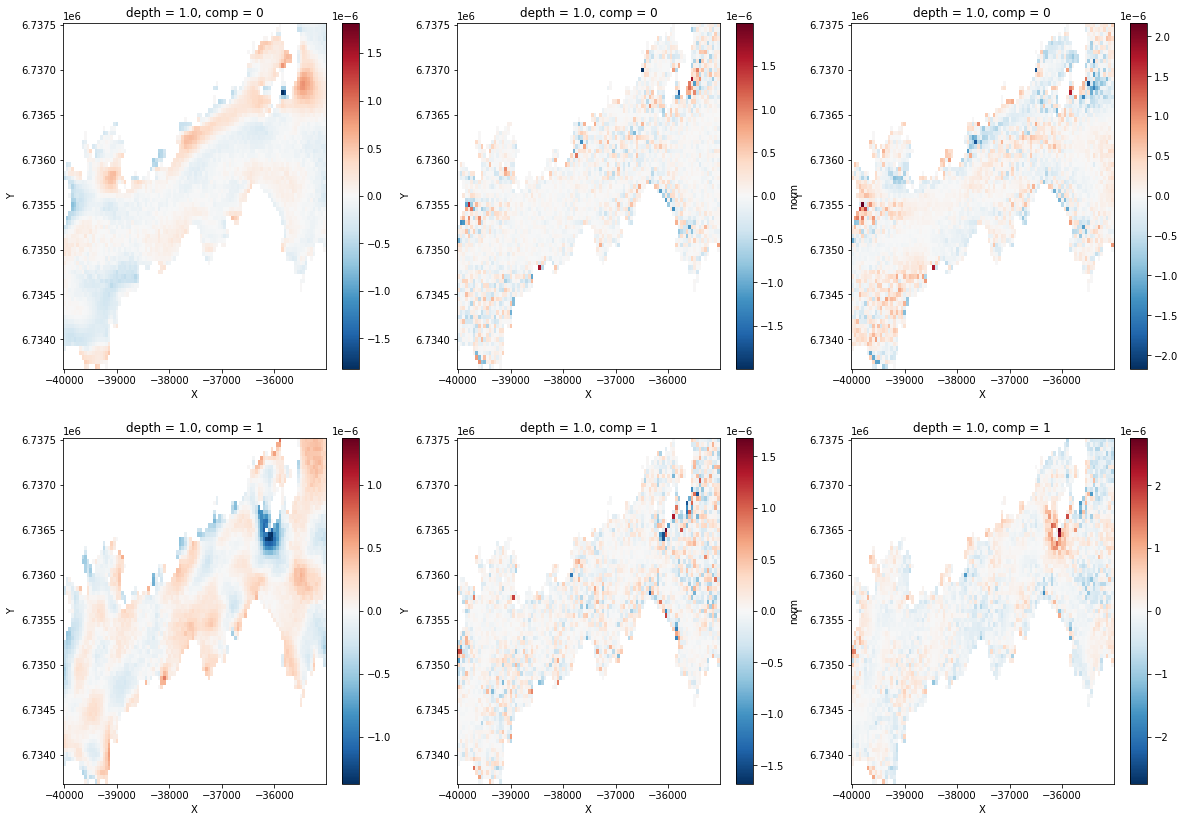

In [108]:
time=100
vmin=tmp.data.norm.isel(time=time).min()
vmax=tmp.data.norm.isel(time=time).max()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,14))
for ii in np.arange(2):
    vel.unstack('z').isel(comp=ii).mean(dim='time').plot(ax=axes[ii,0])
    tmp.data.norm.unstack('z').isel(comp=ii).mean(dim='time').plot(ax=axes[ii,1])
    (tmp.data.norm-vel).unstack('z').isel(comp=ii).mean(dim='time').plot(ax=axes[ii,2])

Some statistics.
Correlation between u and v

## Only one month


In [134]:
reload(GA_cofine)
tmp=GA_cofine.GA_cofine(surface,tresh=0.8)#,vel_names=['u'])

doing SVD analysis


In [188]:
June=tmp.coarse.sel(time=slice('2010-4','2010-4'))
vel=(June.velocity-June['mean'])/June['std']
A6est=tmp.est_PCS(vel)
B6=tmp.calc_PCS(vel)

<xarray.DataArray (mode: 9)>
array([1.2151172, 1.1353418, 1.3437713, 1.4501202, 1.2170123, 1.2798663,
       1.4380602, 1.4316807, 1.340135 ], dtype=float32)
Coordinates:
    depth    float32 1.0
Dimensions without coordinates: mode


In [204]:
Junef=tmp.data.sel(time=slice('2010-4','2010-4'))
velf=Junef.norm#(Junef.velocity-Junef['mean'])/Junef['std']
A6=velf.data@tmp.U.data#tmp.calc_PCS(velf)

In [205]:
((A6.data@tmp.U.data.T)-velf.data).max()

6.6129284

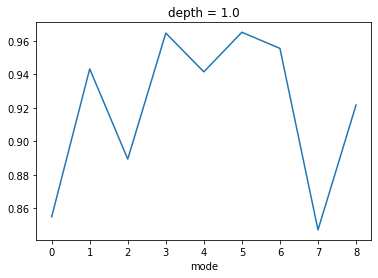

In [150]:

xr.corr(B6,A6est,dim='time').plot()

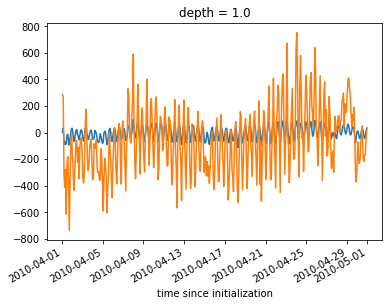

In [145]:
A6.isel(mode=0).plot()
A6est.isel(mode=0).plot()

In [135]:
Uf=Junef.norm*Junef['std']+Junef['mean']


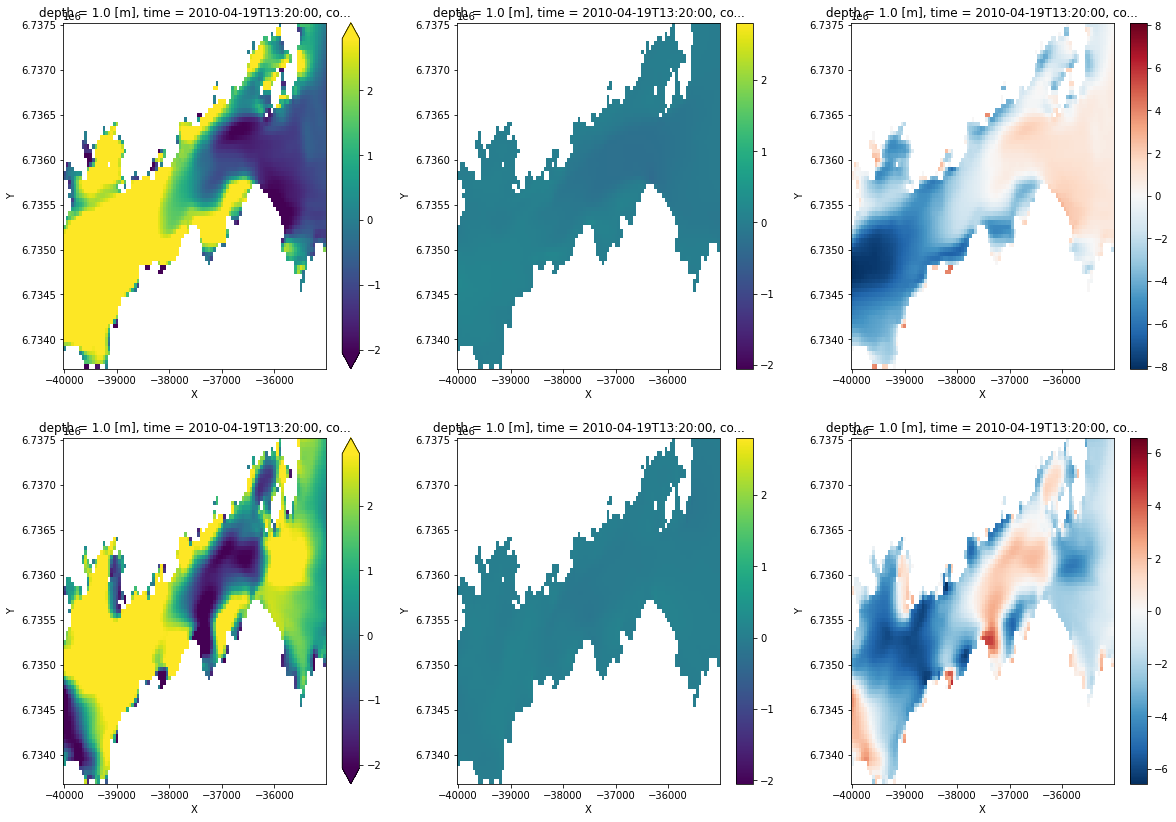

In [136]:
time=250
vmin=Junef.norm.isel(time=time).min()
vmax=Junef.norm.isel(time=time).max()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,14))
for ii in np.arange(2):
    U6.unstack('z').isel(comp=ii,time=time).plot(vmin=vmin,vmax=vmax,ax=axes[ii,0])
    Uf.unstack('z').isel(comp=ii,time=time).plot(vmin=vmin,vmax=vmax,ax=axes[ii,1])
    (Uf-U6).unstack('z').isel(comp=ii,time=time).plot(ax=axes[ii,2])

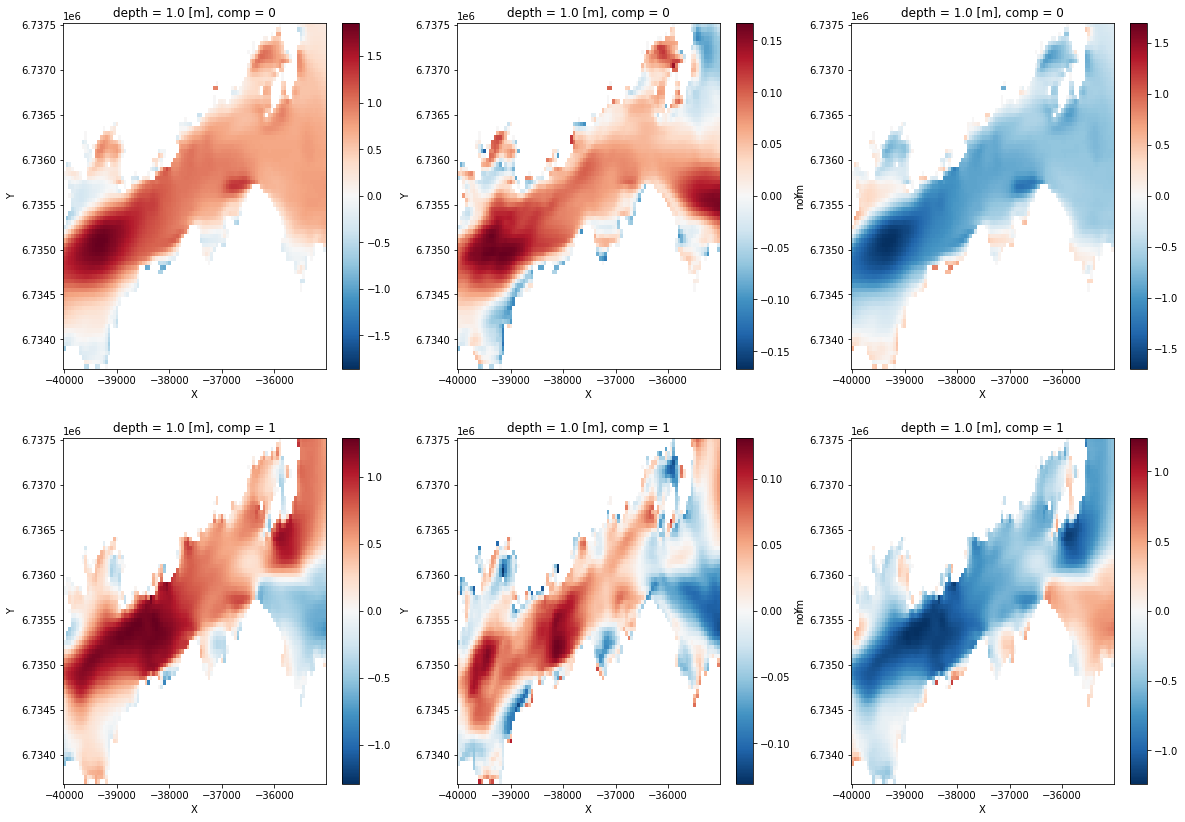

In [137]:

vmin=Junef.norm.isel(time=time).min()
vmax=Junef.norm.isel(time=time).max()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,14))
for ii in np.arange(2):
    U6.unstack('z').isel(comp=ii).mean(dim='time').plot(ax=axes[ii,0])
    Junef.norm.unstack('z').isel(comp=ii).mean(dim='time').plot(ax=axes[ii,1])
    (Junef.norm-U6).unstack('z').isel(comp=ii).mean(dim='time').plot(ax=axes[ii,2])

## Trend and seasonality

In [ ]:
surface.time

<xarray.DataArray 'time' (time: 1501)>
array(['2010-03-27T16:00:00.000000000', '2010-03-27T17:46:40.000000000',
       '2010-03-27T19:33:20.000000000', ..., '2010-07-16T15:06:40.000000000',
       '2010-07-16T16:53:20.000000000', '2010-07-16T18:40:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
Attributes:
    long_name:      time since initialization
    field:          time, scalar, series
    axis:           T
    standard_name:  time

In [ ]:
tmp=surface['u'].drop('depth').mean(dim='X').mean(dim='Y').to_dataframe()
tmp.index

AttributeError: 'DatetimeIndex' object has no attribute 'dt'

In [ ]:
tmp2=STL(tmp).fit()

ValueError: freq S not understood. Please report if you think this is in error.

## SVD of correlation between u and v. 
Using svd_randomized, the matrix is too large. 

In [69]:
res=EOF_funcs.my_svd_randomized(surface)

In [70]:
res

<xarray.Dataset>
Dimensions:           (Y: 82, time: 1501, X: 100, mode: 20)
Coordinates:
  * Y                 (Y) float64 6.733e+06 6.733e+06 ... 6.737e+06 6.737e+06
  * X                 (X) float32 -3.999e+04 -3.994e+04 ... -3.504e+04
    depth             float32 1.0
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
Dimensions without coordinates: mode
Data variables:
    u                 (time, Y, X) float32 0.0 0.0 0.0 ... -0.007282 -0.001192
    v                 (time, Y, X) float32 0.0 0.0 0.0 ... -0.2895 -0.2954
    h                 (Y, X) float32 0.0 0.0 0.0 0.0 ... 127.2 151.3 174.5 197.2
    projection_stere  float32 9.969e+36
    land_binary_mask  (Y, X) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    u_eigen           (mode) float32 1.471e+04 3.957e+03 946.1 ... 34.67 31.78
    u_pcs             (time, mode) float32 10.65 -2.288 ... -0.3932 0.2048
    v_pcs             (time, mode) float32 4.159 -0.7982 ... -0.5156 0.4159
    u_eofs            (mode, Y, X) float32 nan nan nan ... 0.007629 0.0104
    v_eofs            (mode, Y, X) float32 nan nan nan ... 0.008972 -0.0008548
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

The singular values

Text(0, 0.5, 'Singular values')

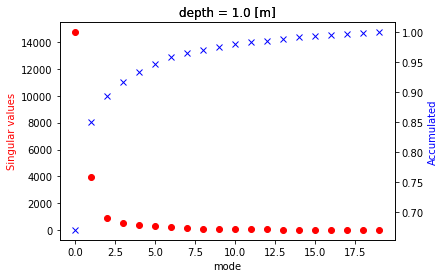

In [71]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
res.u_eigen.plot.line('ro',ax=ax1)
(res.u_eigen.cumsum()/res.u_eigen.sum()).plot.line('bx',ax=ax2)
ax2.set_ylabel('Accumulated', color='b')
ax1.set_ylabel('Singular values', color='r')


In [72]:
res=res.drop('depth')

Text(0.04, 0.5, 'y coordinate [m]')

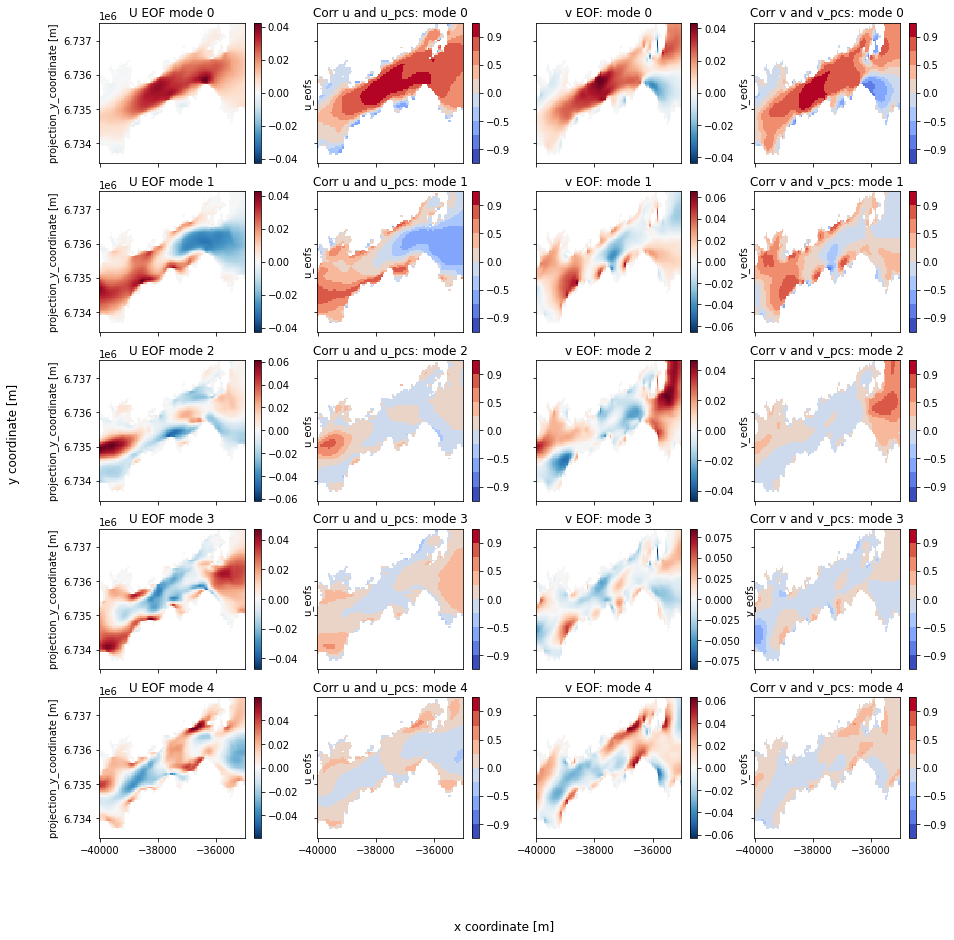

In [73]:
rows=5
levels=[-1,-0.9,-0.7,-0.5,-0.3,0,0.3,0.5,0.7,0.9,1]
cmap='coolwarm'
fig, axes = plt.subplots(ncols=4, nrows=rows, figsize=(15,15),sharex=True,sharey=True)

for ii in np.arange(rows):
    res.u_eofs.isel(mode=ii).plot(ax=axes[ii,0])
    axes[ii,0].set_xlabel('')
    axes[ii,0].set_title('U EOF mode ' + str(ii))
    xr.corr(res.u_pcs.isel(mode=ii),res.u,dim='time').plot(ax=axes[ii,1],vmin=-1,vmax=1,levels=levels,cmap=cmap)
    axes[ii,1].set_xlabel('')
    axes[ii,1].set_ylabel('')
    axes[ii,1].set_title('Corr u and u_pcs: mode ' + str(ii))
    res.v_eofs.isel(mode=ii).plot(ax=axes[ii,2])
    axes[ii,2].set_xlabel('')
    axes[ii,2].set_ylabel('')
    axes[ii,2].set_title('v EOF: mode ' + str(ii))
    xr.corr(res.v_pcs.isel(mode=ii),res.v,dim='time').plot(ax=axes[ii,3],vmin=-1,vmax=1,levels=levels,cmap=cmap,label='')
    axes[ii,3].set_xlabel('')
    axes[ii,3].set_ylabel('')
    axes[ii,3].set_title('Corr v and v_pcs: mode ' + str(ii))
fig.text(0.5, 0.04, 'x coordinate [m]', ha='center', fontsize='large')
fig.text(0.04, 0.5, 'y coordinate [m]', va='center', rotation='vertical',fontsize='large')

In [74]:
np.arange(20)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [75]:
res=res.assign_coords(mode=('mode',np.arange(20)))
res

<xarray.Dataset>
Dimensions:           (Y: 82, time: 1501, X: 100, mode: 20)
Coordinates:
  * Y                 (Y) float64 6.733e+06 6.733e+06 ... 6.737e+06 6.737e+06
  * X                 (X) float32 -3.999e+04 -3.994e+04 ... -3.504e+04
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
  * mode              (mode) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
Data variables:
    u                 (time, Y, X) float32 0.0 0.0 0.0 ... -0.007282 -0.001192
    v                 (time, Y, X) float32 0.0 0.0 0.0 ... -0.2895 -0.2954
    h                 (Y, X) float32 0.0 0.0 0.0 0.0 ... 127.2 151.3 174.5 197.2
    projection_stere  float32 9.969e+36
    land_binary_mask  (Y, X) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    u_eigen           (mode) float32 1.471e+04 3.957e+03 946.1 ... 34.67 31.78
    u_pcs             (time, mode) float32 10.65 -2.288 ... -0.3932 0.2048
    v_pcs             (time, mode) float32 4.159 -0.7982 ... -0.5156 0.4159
    u_eofs            (mode, Y, X) float32 nan nan nan ... 0.007629 0.0104
    v_eofs            (mode, Y, X) float32 nan nan nan ... 0.008972 -0.0008548
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [76]:
res.time

<xarray.DataArray 'time' (time: 1501)>
array(['2010-03-27T16:00:00.000000000', '2010-03-27T17:46:40.000000000',
       '2010-03-27T19:33:20.000000000', ..., '2010-07-16T15:06:40.000000000',
       '2010-07-16T16:53:20.000000000', '2010-07-16T18:40:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
Attributes:
    long_name:      time since initialization
    field:          time, scalar, series
    axis:           T
    standard_name:  time

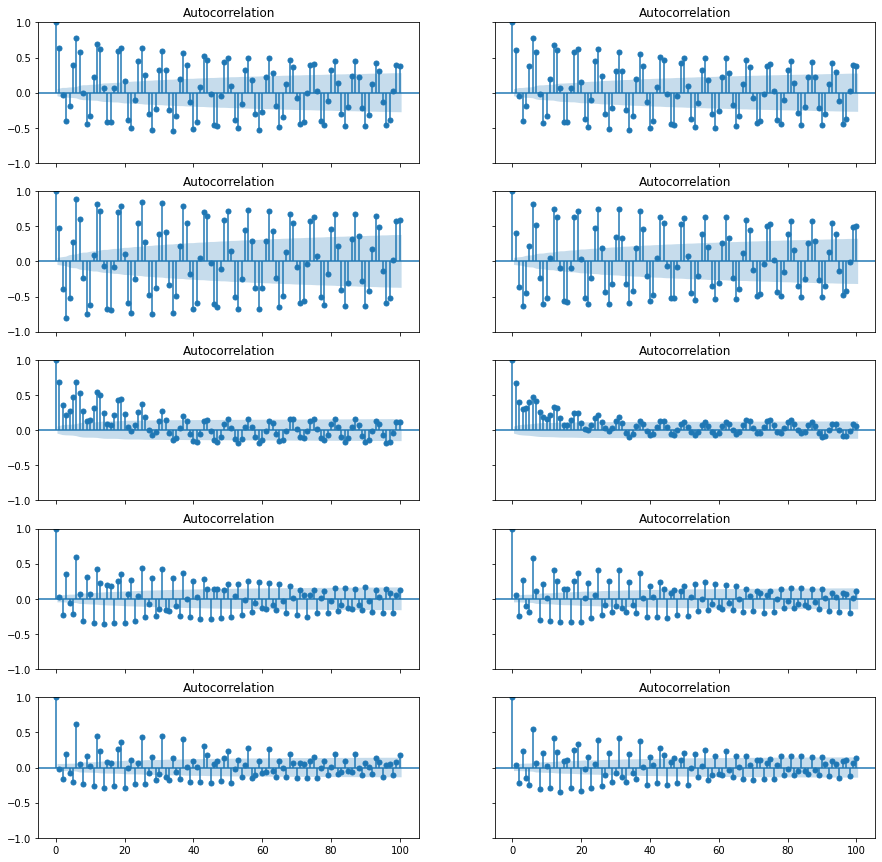

In [77]:
rows=5
lags=100
levels=[-1,-0.9,-0.7,-0.5,-0.3,0,0.3,0.5,0.7,0.9,1]
cmap='coolwarm'
fig, axes = plt.subplots(ncols=2, nrows=rows, figsize=(15,15),sharex=True,sharey=True)

for ii in np.arange(rows):
    plot_acf(res.u_pcs.isel(mode=ii).data,lags=lags,ax=axes[ii,0])
    plot_acf(res.v_pcs.isel(mode=ii).data,lags=lags,ax=axes[ii,1])

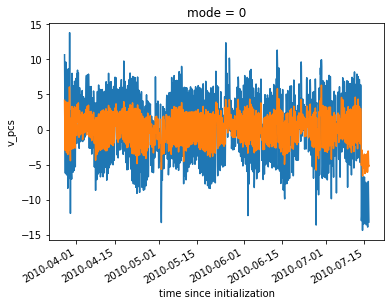

In [78]:

res.u_pcs.isel(mode=0).plot.line(x='time')
res.v_pcs.isel(mode=0).plot.line(x='time')


In [79]:
res['month']=res['time.month']

In [80]:
res

<xarray.Dataset>
Dimensions:           (Y: 82, time: 1501, X: 100, mode: 20)
Coordinates:
  * Y                 (Y) float64 6.733e+06 6.733e+06 ... 6.737e+06 6.737e+06
  * X                 (X) float32 -3.999e+04 -3.994e+04 ... -3.504e+04
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
  * mode              (mode) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
Data variables:
    u                 (time, Y, X) float32 0.0 0.0 0.0 ... -0.007282 -0.001192
    v                 (time, Y, X) float32 0.0 0.0 0.0 ... -0.2895 -0.2954
    h                 (Y, X) float32 0.0 0.0 0.0 0.0 ... 127.2 151.3 174.5 197.2
    projection_stere  float32 9.969e+36
    land_binary_mask  (Y, X) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    u_eigen           (mode) float32 1.471e+04 3.957e+03 946.1 ... 34.67 31.78
    u_pcs             (time, mode) float32 10.65 -2.288 ... -0.3932 0.2048
    v_pcs             (time, mode) float32 4.159 -0.7982 ... -0.5156 0.4159
    u_eofs            (mode, Y, X) float32 nan nan nan ... 0.007629 0.0104
    v_eofs            (mode, Y, X) float32 nan nan nan ... 0.008972 -0.0008548
    month             (time) int64 3 3 3 3 3 3 3 3 3 3 3 ... 7 7 7 7 7 7 7 7 7 7
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

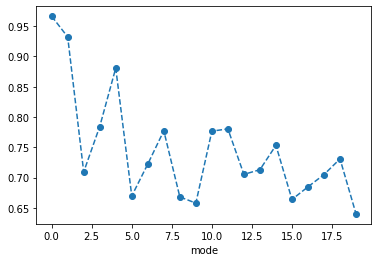

In [81]:
xr.corr(res.u_pcs,res.v_pcs,dim='time').plot.line('o--')

## Coarse vs fine grid. 

Create a coarse version of the data. 

In [82]:
xskip=6
yskip=xskip
coarse=surface.isel(Y=slice(0,surface.dims['Y'],yskip),X=slice(0,surface.dims['X'],xskip))
coarse=EOF_funcs.my_mask(coarse)

focus=EOF_funcs.my_mask(surface)
u=focus.ucent#+focus.vcent.data*1j
v=coarse.ucent#+coarse.vcent.data*1j

Cmat=(np.transpose(u.data)@v.data)

U,L,Vt=np.linalg.svd(Cmat)

In [83]:
modes=10
U=U[:,0:modes]
V=Vt.T[:,0:modes]
L=L[0:modes]

In [84]:
B=v.data@V
uc=xr.DataArray(B@np.transpose(V),coords=coarse.v.coords)
A=u.data@U
uf=xr.DataArray(A@np.transpose(U),coords=focus.u.coords)
Aest=(np.diag(L)@np.linalg.pinv(B)).T
uu=xr.DataArray(Aest@U.T,coords=focus.u.coords)



In [85]:
A=xr.DataArray(A,dims=('time','mode'))
B=xr.DataArray(B,dims=('time','mode'))

Aest=xr.DataArray(Aest,dims=('time','mode'))

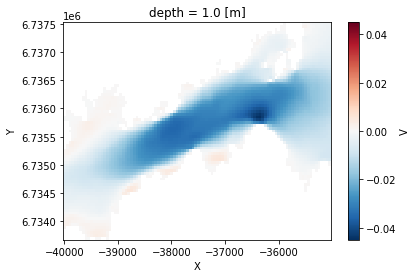

In [87]:

tmp=xr.Dataset(data_vars=dict(V=(['z','mode'],U)),coords=focus.v.coords)
tmp.isel(mode=0).unstack('z').V.plot()

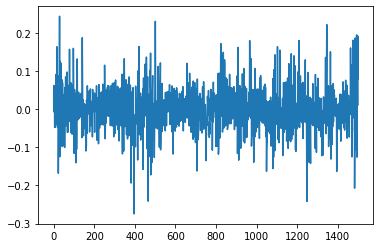

In [88]:
plt.plot((A-Aest)[:,0])

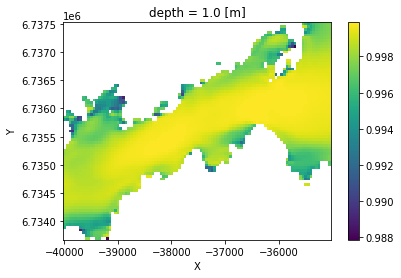

In [89]:
Au_corr=xr.corr(uf,uu,dim='time')
Au_corr.unstack('z').plot()

In [90]:
new=coarse.sel(time='2010-5')
nfoc=focus.sel(time='2010-5')
nu=new.vcent
Bn=nu.data@V
An=nfoc.vcent.data@U
Anest=((coarse.dims['time']-1)/(new.dims['time']-1))**(1/2)*(np.diag(L)@np.linalg.pinv(Bn)).T

In [91]:
new

<xarray.Dataset>
Dimensions:           (time: 418, z: 98)
Coordinates:
    depth             float32 1.0
  * time              (time) datetime64[ns] 2010-05-01T00:53:20 ... 2010-05-3...
  * z                 (z) MultiIndex
  - Y                 (z) float64 6.734e+06 6.734e+06 ... 6.737e+06 6.737e+06
  - X                 (z) float64 -3.939e+04 -3.999e+04 ... -3.519e+04
Data variables: (12/13)
    u                 (time, z) float32 -0.04188 -0.02179 ... 0.003652 -0.01117
    v                 (time, z) float32 -0.00124 -0.02147 ... -0.03225 -0.05761
    h                 (z) float32 9.667 93.13 115.4 93.87 ... 167.6 14.32 125.1
    projection_stere  (z) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    land_binary_mask  (z) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    umean             (z) float32 -0.02304 0.02495 ... -0.001285 -0.009172
    ...                ...
    ustd              (z) float32 0.03225 0.06795 0.06388 ... 0.004045 0.02694
    vstd              (z) float32 0.009673 0.02138 0.026 ... 0.06184 0.07861
    ucent             (time, z) float32 -0.01885 -0.04674 ... 0.004937 -0.001994
    unorm             (time, z) float32 -0.5845 -0.6879 ... 1.221 -0.07403
    vcent             (time, z) float32 -0.0008333 -0.01988 ... 0.00944 -0.02193
    vnorm             (time, z) float32 -0.08615 -0.9299 ... 0.1527 -0.2789
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

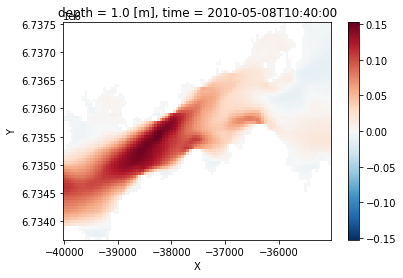

In [92]:
tmp=xr.DataArray(An@U.T,coords=focus.sel(time='2010-5').v.coords)
tmp.unstack('z').isel(time=100).plot()#vmin=-0.2,vmax=0.2)

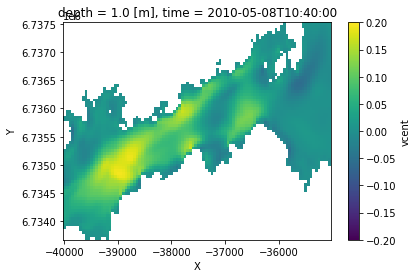

In [93]:
nfoc.vcent.unstack('z').isel(time=100).plot(vmin=-0.2,vmax=0.2)

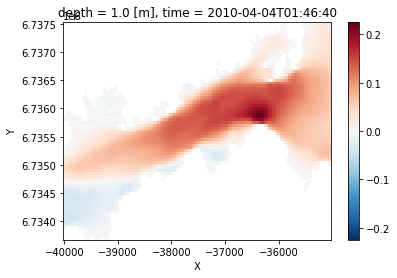

In [94]:
uu.isel(time=100).unstack('z').plot()

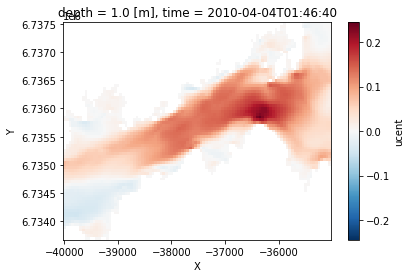

In [95]:
u.isel(time=100).unstack('z').plot()

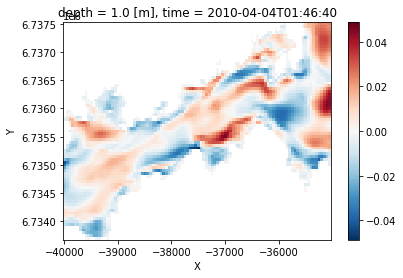

In [96]:
(uu-u).isel(time=100).unstack('z').plot()

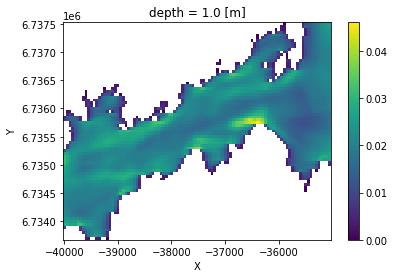

In [97]:
(u-uu).std(dim='time').unstack('z').plot()

In [98]:
uf6=focus.sel(time=slice('2010-6','2010-6'))
uc6=coarse.sel(time=slice('2010-6','2010-6'))

uf6=my_mask(uf6.unstack('z'),calcMeans=True)
uc6=my_mask(uc6.unstack('z'),calcMeans=True)



NameError: name 'my_mask' is not defined

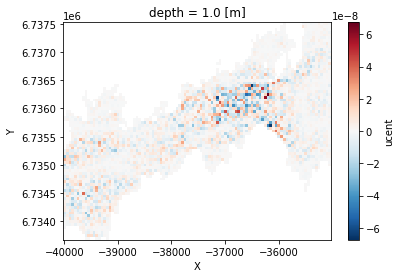

In [ ]:
uf6.ucent.mean(dim='time').unstack('z').plot()

In [ ]:
np.var(B)

0.20180805

In [ ]:
rho=np.var(B,axis=0) #np.var(u.data.T)*
B6=uc6.ucent.data@V
#uc6=xr.DataArray(B@V.T,coords=u6.coords)
A6=np.linalg.pinv(B6).T@np.diag(np.var(B6,axis=0)*L/rho) #np.linalg.pinv(B6).T@np.diag(L)
print(np.shape(A6))
uu6=xr.DataArray(A6@U.T,coords=uf6.coords)

(405, 10)


In [ ]:
L

array([8736.52    , 2193.2837  ,  426.88983 ,  293.5089  ,  140.355   ,
         99.364426,   83.71509 ,   69.47541 ,   53.251366,   42.068893],
      dtype=float32)

(<matplotlib.image.AxesImage at 0x7fe55ff52b50>,
 <matplotlib.colorbar.Colorbar at 0x7fe55ff52fd0>)

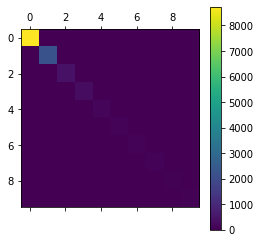

In [ ]:
plt.matshow(A.T@B), plt.colorbar()

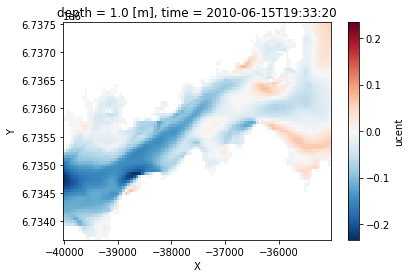

In [ ]:
uf6.ucent.isel(time=200).unstack('z').plot()

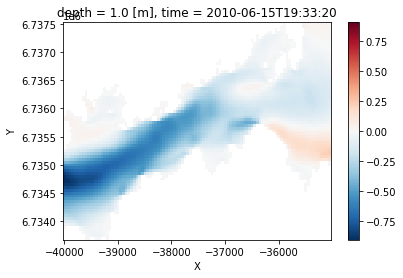

In [ ]:
uu6.isel(time=200).unstack('z').plot()

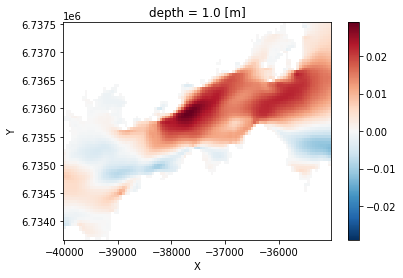

In [ ]:
(uu6).mean(dim='time').unstack('z').plot()

In [ ]:
u1=uu.sel(time=slice('2010-2','2010-5'))
v1=vv.sel(time=slice('2010-2','2010-5'))
u1,l1,v1t=np.linalg.svd(u1.data.T@v1.data)

In [ ]:
uu.mean(dim='time')

<xarray.DataArray 'u' (z: 8200)>
array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
       -2.0874491e-05, -2.5157766e-05, -2.8489432e-05], dtype=float32)
Coordinates:
    depth    float32 1.0
  * z        (z) MultiIndex
  - Y        (z) float64 6.733e+06 6.733e+06 6.733e+06 ... 6.737e+06 6.737e+06
  - X        (z) float64 -3.999e+04 -3.994e+04 ... -3.509e+04 -3.504e+04

(0.0, 10.0)

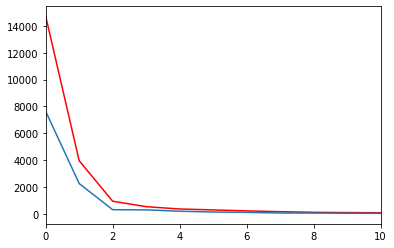

In [ ]:
plt.plot(l,'r')
plt.plot(l1)
plt.xlim(0,10)

(0.0, 20.0)

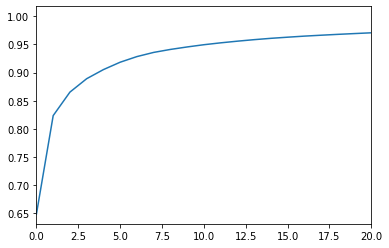

In [ ]:
plt.plot(l.cumsum()/l.sum())
plt.xlim(0,20)

In [ ]:
modes=300
UU=u1[:,0:modes]
VV=v1t.T[:,0:modes]
A=uu.data@UU
u_res=xr.DataArray(A@UU.T,coords=uu.coords)
B=vv.data@VV
BB=np.linalg.pinv(A.T)@np.diag(l1[0:modes])
v_res=xr.DataArray(B@VV.T,coords=vv.coords)
v_est=xr.DataArray(BB@VV.T,coords=vv.coords)

In [ ]:
np.shape(l[0:modes]/B.mean(axis=0))

(300,)

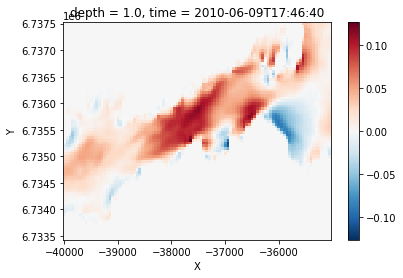

In [ ]:
v_res.unstack('z').isel(time=1000).plot()

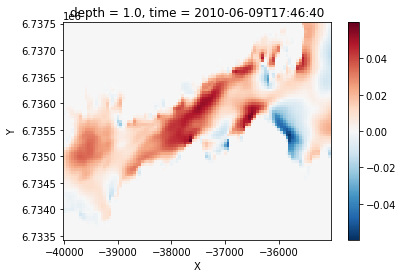

In [ ]:
v_est.unstack('z').isel(time=1000).plot()

In [ ]:
uj=uu.sel(time=slice('2010-6','2010-6'))
vj=vv.sel(time=slice('2010-6','2010-6'))
Aj=uj.data@UU
uj_res=xr.DataArray(Aj@UU.T,coords=uj.coords)
Bj=vj.data@VV
BBj=np.linalg.pinv(Aj.T)@np.diag(l1[0:modes])
vj_res=xr.DataArray(Bj@VV.T,coords=vj.coords)
vj_est=xr.DataArray(BBj@VV.T,coords=vj.coords)


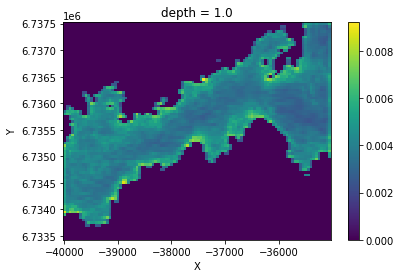

In [ ]:
(uj-uj_res).unstack('z').std(dim='time').plot()

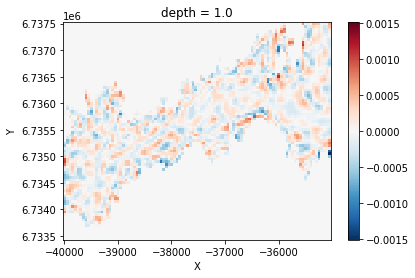

In [ ]:
(vj-vj_res).unstack('z').mean(dim='time').plot()

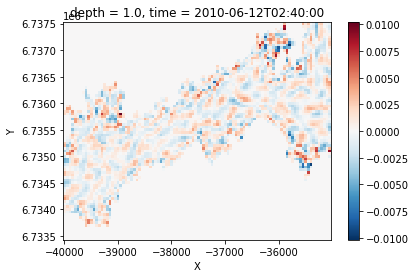

In [ ]:
(vj-vj_res).unstack('z').isel(time=150).plot()

## coarse to fine


In [ ]:
focus

<xarray.Dataset>
Dimensions:           (time: 1501, Y: 82, X: 100)
Coordinates:
  * X                 (X) float32 -3.999e+04 -3.994e+04 ... -3.504e+04
  * Y                 (Y) float32 6.733e+06 6.733e+06 ... 6.737e+06 6.737e+06
    depth             float32 1.0
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
Data variables:
    u                 (time, Y, X) float32 0.0 0.0 0.0 ... -0.007282 -0.001192
    v                 (time, Y, X) float32 0.0 0.0 0.0 ... -0.2895 -0.2954
    h                 (Y, X) float32 0.0 0.0 0.0 0.0 ... 127.2 151.3 174.5 197.2
    projection_stere  float32 9.969e+36
    land_binary_mask  (Y, X) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [ ]:

focus=focus
uu=(focus.u-focus.u.mean(dim='time')).stack(z=['Y','X']).interpolate_na(dim='time')
tmp=focus.isel(Y=slice(0,82,4),X=slice(0,100,4))
vv=(tmp.u-tmp.u.mean(dim='time')).stack(z=['Y','X']).interpolate_na(dim='time')

u1=uu.sel(time=slice('2010-2','2010-5'))
v1=vv.sel(time=slice('2010-2','2010-5'))
u2,l2,v2t=np.linalg.svd(u1.data.T@v1.data)

In [ ]:
v2t@v2t.T

array([[ 1.0000000e+00,  0.0000000e+00, -1.1175871e-08, ...,
         0.0000000e+00,  0.0000000e+00,  2.9360703e-17],
       [ 0.0000000e+00,  1.0000000e+00,  2.9802322e-08, ...,
         0.0000000e+00,  0.0000000e+00,  4.6741184e-17],
       [-1.1175871e-08,  2.9802322e-08,  1.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  6.2173065e-17],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  9.9999994e-01,  0.0000000e+00],
       [ 2.9360703e-17,  4.6741184e-17,  6.2173065e-17, ...,
         0.0000000e+00,  0.0000000e+00,  9.9999994e-01]], dtype=float32)

(0.0, 10.0)

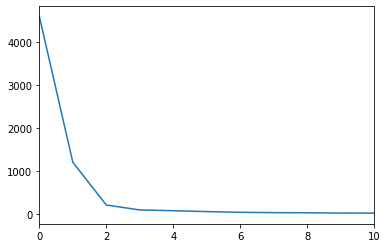

In [ ]:
plt.plot(l2)
plt.xlim(0,10)

In [ ]:
modes=525
UU=u2[:,0:modes]
VV=v2t.T[:,0:modes]
A=u1.data@UU
u_res=xr.DataArray(A@UU.T,coords=u1.coords)
B=v1.data@VV
AA=np.linalg.pinv(B).T@np.diag(l1[0:modes]).T
v_res=xr.DataArray(B@VV.T,coords=v1.coords)
u_est=xr.DataArray(AA@UU.T,coords=u1.coords)

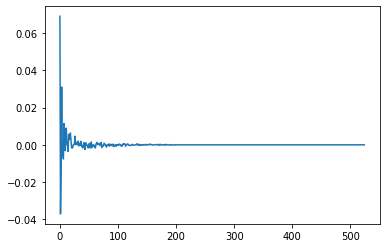

In [ ]:
plt.plot(np.mean(B,axis=0))

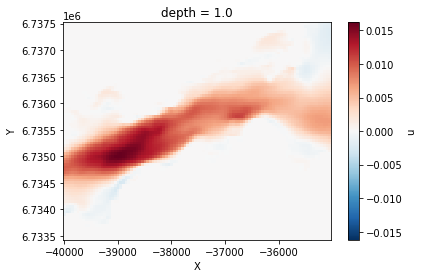

In [ ]:
u1.unstack('z').mean(dim='time').plot()

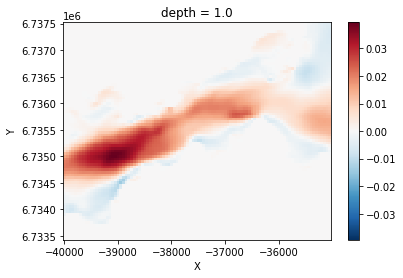

In [ ]:
u_est.unstack('z').mean(dim='time').plot()

In [ ]:
np.shape(v2t)

(8200, 8200)

In [ ]:
tmp=data.isel(depth=0).stack(z=['Y','X'])
tmp=tmp.where(tmp.land_binary_mask==0, drop=True)


<xarray.Dataset>
Dimensions:           (time: 1501, z: 28375)
Coordinates:
    depth             float32 1.0
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
  * z                 (z) MultiIndex
  - Y                 (z) float64 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X                 (z) float64 -4.124e+04 -4.119e+04 ... -3.214e+04
Data variables:
    u                 (time, z) float32 0.0 0.0 0.0 ... -0.02036 -0.003527
    v                 (time, z) float32 0.0 0.0 0.0 ... 0.089 0.06619 0.02443
    h                 (z) float32 23.12 33.01 46.57 61.09 ... 58.12 58.02 58.58
    projection_stere  (z) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    land_binary_mask  (z) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [ ]:
tmp

<xarray.Dataset>
Dimensions:           (time: 1501, z: 28375)
Coordinates:
    depth             float32 1.0
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
  * z                 (z) MultiIndex
  - Y                 (z) float64 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X                 (z) float64 -4.124e+04 -4.119e+04 ... -3.214e+04
Data variables:
    u                 (time, z) float32 0.0 0.0 0.0 ... -0.02036 -0.003527
    v                 (time, z) float32 0.0 0.0 0.0 ... 0.089 0.06619 0.02443
    h                 (z) float32 23.12 33.01 46.57 61.09 ... 58.12 58.02 58.58
    projection_stere  (z) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    land_binary_mask  (z) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [ ]:
data_coarse=data.isel(depth=0,Y=slice(0,400,8),X=slice(0,200,8))
data_coarse=data_coarse.stack(z=['Y','X'])
data_coarse=data_coarse.where(data_coarse.land_binary_mask==0, drop=True)
data_coarse

<xarray.Dataset>
Dimensions:           (time: 1501, z: 454)
Coordinates:
    depth             float32 1.0
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
  * z                 (z) MultiIndex
  - Y                 (z) float64 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X                 (z) float64 -4.104e+04 -4.064e+04 ... -3.224e+04
Data variables:
    u                 (time, z) float32 0.0 0.0 0.0001086 ... -0.01945 -0.01627
    v                 (time, z) float32 0.0 0.0 0.0002551 ... 0.01437 0.1182
    h                 (z) float32 73.4 10.98 45.86 23.22 ... 29.78 16.75 56.3
    projection_stere  (z) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    land_binary_mask  (z) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [ ]:
u_coarse=data_coarse.u.interpolate_na(dim='time')
u_coarse=u_coarse-u_coarse.mean(dim='time')
v_coarse=data_coarse.v.interpolate_na(dim='time')
v_coarse=v_coarse-v_coarse.mean(dim='time')

In [ ]:
np.isnan(v_coarse).sum()

<xarray.DataArray 'v' ()>
array(0)
Coordinates:
    depth    float32 1.0

In [ ]:
data_stacked=data.isel(depth=0).stack(z=['Y','X'])
data_stacked=data_stacked.where(data_stacked.land_binary_mask==0, drop=True)
u_fine=data_stacked.u.interpolate_na(dim='time')
u_fine=u_fine-u_fine.mean(dim='time')
v_fine=data_stacked.v.interpolate_na(dim='time')
v_fine=v_fine-v_fine.mean(dim='time')


In [ ]:
np.shape(u_fine)

(1501, 28375)

In [ ]:
Cu=u_fine.data.T@u_fine.data

MemoryError: Unable to allocate 3.00 GiB for an array with shape (28375, 28375) and data type float32

In [ ]:
vel_fine=np.concatenate((u_fine,v_fine),axis=1)
vel_coarse=np.concatenate((u_coarse,v_coarse),axis=1)

In [ ]:
vel_coarse

array([[ 0.00000000e+00,  0.00000000e+00,  1.20929151e-04, ...,
        -3.98178305e-03, -2.26855464e-03,  1.84790611e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.06203852e-05, ...,
        -1.67757273e-04, -8.23757052e-03, -8.38354602e-03],
       [ 0.00000000e+00,  0.00000000e+00, -1.02626866e-04, ...,
        -2.72987178e-03,  5.59555460e-03, -1.63549617e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00, -5.01243157e-05, ...,
        -1.43436599e-04,  2.53369324e-02,  1.00108698e-01],
       [ 0.00000000e+00,  0.00000000e+00, -6.36391051e-05, ...,
        -3.58514907e-03,  2.17907541e-02,  9.24086869e-02],
       [ 0.00000000e+00,  0.00000000e+00,  1.93456708e-06, ...,
        -3.97800002e-03,  9.21225734e-03,  5.92405014e-02]], dtype=float32)

In [ ]:
C=vel_coarse.T@vel_fine
np.shape(C)

(908, 56750)

In [ ]:
u,l,vt=np.linalg.svd(C)

MemoryError: Unable to allocate 24.0 GiB for an array with shape (56750, 56750) and data type float64

In [ ]:
U,L,VT=randomized_svd(C,30,random_state=0)

In [ ]:
A=vel_coarse.data@U
B=vel_fine.data@VT.T
B_est=np.linalg.pinv(A.T)@np.diag(L)

In [ ]:
vel1c=A@U.T
vel1f=B@VT
vel1e=B_est@VT

In [ ]:
def my_split(inarr, coords):
    tmp=np.split(inarr,2,axis=1)
    u=xr.DataArray(tmp[0],coords=coords)
    v=xr.DataArray(tmp[1],coords=coords)
    return u,v

In [ ]:
u1c,v1c=my_split(vel1c,coords=u_coarse.coords)
u1f,v1f=my_split(vel1f,coords=u_fine.coords)
u1e,v1e=my_split(vel1e,coords=u_fine.coords)

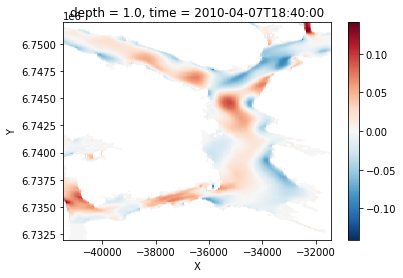

In [ ]:
v1f.isel(time=150).unstack('z').plot()

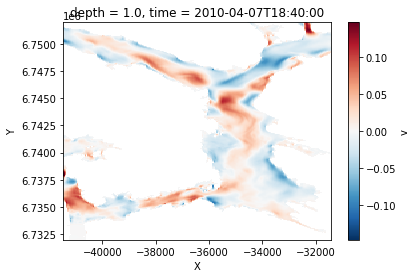

In [ ]:
v_fine.isel(time=150).unstack('z').plot()

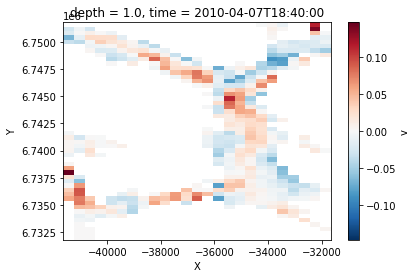

In [ ]:
v_coarse.isel(time=150).unstack('z').plot()

In [ ]:
u_test=u_coarse.isel(time=u_coarse.time.dt.month.isin(6))
v_test=v_coarse.isel(time=v_coarse.time.dt.month.isin(6))
uu=u_fine.isel(time=u_fine.time.dt.month.isin(6))
vel_test=np.concatenate((u_test,v_test),axis=1)
Atest=vel_test@U
Btest=np.linalg.pinv(Atest.T)@np.diag(L)
vel1test=Btest@VT
u1test,v1test=my_split(vel1test,uu.coords)

(<matplotlib.image.AxesImage at 0x7fd1619a9d90>,
 <matplotlib.colorbar.Colorbar at 0x7fd16199edc0>)

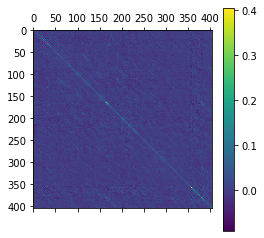

In [ ]:
plt.matshow(np.linalg.pinv(Atest.T)@Atest.T),plt.colorbar()

In [ ]:
print(u1test.isel(time=100).time.values)
print(uu.isel(time=100).time.values)

2010-06-08T09:46:40.000000000
2010-06-08T09:46:40.000000000


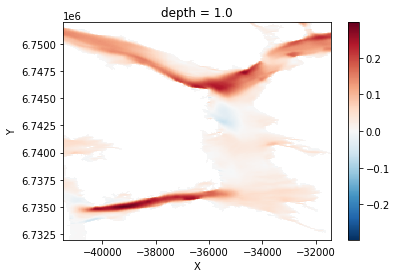

In [ ]:
u1test.unstack('z').mean(dim='time').plot()

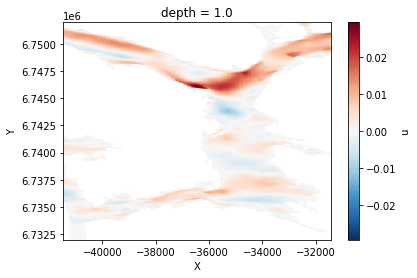

In [ ]:
uu.unstack('z').mean(dim='time').plot()

In [ ]:
# Select only May and surface
June=data.isel(time=data.time.dt.month.isin(6),depth=0)
April=data.isel(time=data.time.dt.month.isin(4),depth=1)

In [ ]:
np.isnan(April.u).sum()

<xarray.DataArray 'u' ()>
array(0)
Coordinates:
    depth    float32 3.0

In [ ]:
June_stacked=June.stack(z=('Y','X'))
April_stacked=April.stack(z=('Y','X'))

In [ ]:
data6=June_stacked.where(June_stacked.land_binary_mask==0, drop=True)
data4=April_stacked.where(April_stacked.land_binary_mask==0, drop=True)
data4

<xarray.Dataset>
Dimensions:           (time: 405, z: 28375)
Coordinates:
    depth             float32 3.0
  * time              (time) datetime64[ns] 2010-04-01T00:53:20 ... 2010-04-3...
  * z                 (z) MultiIndex
  - Y                 (z) float64 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X                 (z) float64 -4.124e+04 -4.119e+04 ... -3.214e+04
Data variables:
    u                 (time, z) float32 0.0 0.0 0.0 ... 0.002662 0.003315
    v                 (time, z) float32 0.0 0.0 0.0 ... 0.01941 0.02072 0.02232
    h                 (z) float32 23.12 33.01 46.57 61.09 ... 58.12 58.02 58.58
    projection_stere  (z) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    land_binary_mask  (z) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [ ]:
data_coarse=data6.isel(z=slice(0,28375,1000)).dropna(dim='time')
test_coarse=data4.isel(z=slice(0,28375,1000)).dropna(dim='time')

In [ ]:
u_fine=data6.u-data6.u.mean(dim='time')
u_coarse=data_coarse.u-data_coarse.u.mean(dim='time')
u_test=test_coarse.u-test_coarse.u.mean(dim='time')

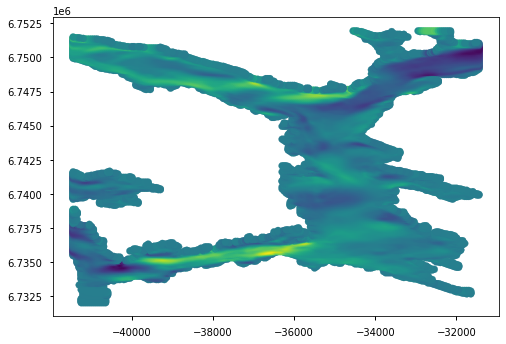

In [ ]:
plt.scatter(x=u_fine.isel(time=100).X,y=u_fine.isel(time=100).Y,c=u_fine.isel(time=100))

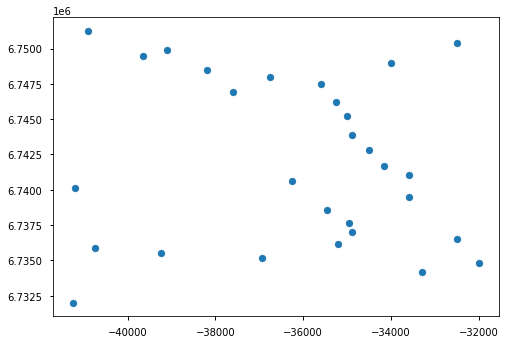

In [ ]:
plt.scatter(x=u_test.X,y=u_test.Y)

In [ ]:
C=u_coarse.data.T@u_fine.data

In [ ]:
U,L,VT=randomized_svd(C,150,random_state=0)

In [ ]:
A=u_coarse.data@U
B_est=np.linalg.pinv(A.T)@np.diag(L)

In [ ]:
A_test=u_test.data@U
B_test=np.linalg.pinv(A_test.T)@np.diag(L)

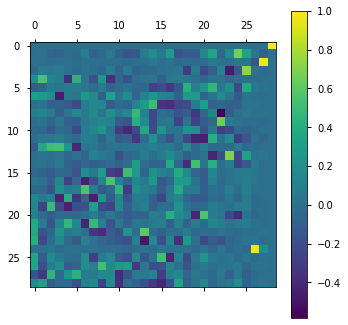

In [ ]:
plt.matshow(U)
plt.colorbar()

In [ ]:
B=u_fine.data@VT.T


In [ ]:
u_test.max()

<xarray.DataArray 'u' ()>
array(0.18218964, dtype=float32)
Coordinates:
    depth    float32 3.0

In [ ]:
u_est=xr.DataArray(B_test@VT,coords=data4.coords)
u_est.max()

<xarray.DataArray ()>
array(250648.52, dtype=float32)
Coordinates:
    depth    float32 3.0

In [ ]:
data4.u

<xarray.DataArray 'u' (time: 405, z: 28375)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.00401845,
        -0.0010604 , -0.00147808],
       [ 0.        ,  0.        ,  0.        , ...,  0.02109829,
         0.01604008,  0.00644687],
       [ 0.        ,  0.        ,  0.        , ...,  0.00564489,
         0.01245364,  0.00683325],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.01176799,
        -0.00069676,  0.00210808],
       [ 0.        ,  0.        ,  0.        , ..., -0.01063677,
        -0.00607965, -0.00177541],
       [ 0.        ,  0.        ,  0.        , ..., -0.00461948,
         0.00266164,  0.00331459]], dtype=float32)
Coordinates:
    depth    float32 3.0
  * time     (time) datetime64[ns] 2010-04-01T00:53:20 ... 2010-04-30T23:06:40
  * z        (z) MultiIndex
  - Y        (z) float64 6.732e+06 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X        (z) float64 -4.124e+04 -4.119e+04 ... -3.219e+04 -3.214e+04
Attributes:
    units:          meter second-1
    time:           ocean_time
    field:          u-velocity, scalar, series
    grid_mapping:   projection_stere
    long_name:      Sea water x velocity
    standard_name:  x_sea_water_velocity
    coordinates:    lon lat

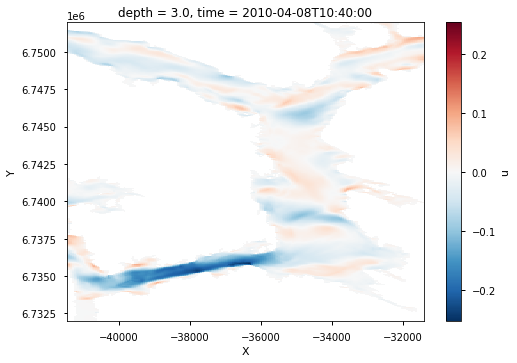

In [ ]:
(data4.u-data4.u.mean(dim='time')).isel(time=100).unstack('z').plot()

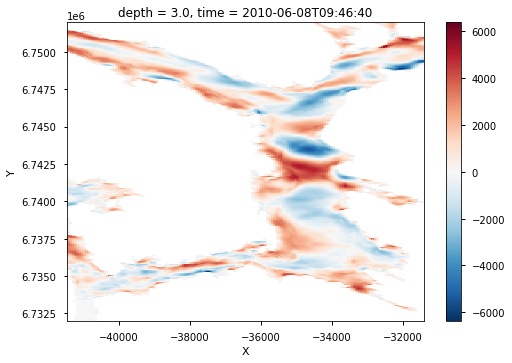

In [ ]:
u_est.unstack('z').isel(time=100).plot()

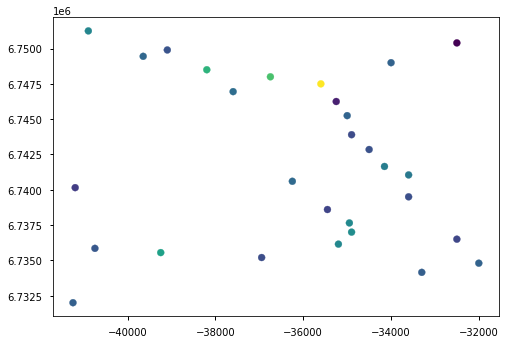

In [ ]:
plt.scatter(x=u_coarse.X,y=u_coarse.Y,c=u_coarse.isel(time=100))

In [ ]:

June_stacked['u_mean']=June_stacked.u.mean(dim='time')
June_stacked['v_mean']=June_stacked.v.mean(dim='time')

Do the tide extraction

In [ ]:
do_tide=False

if do_tide:
    May_stacked_wet=May_stacked.where(May_stacked.land_binary_mask==0).dropna(dim='z')
    tide=my_tide(May_stacked_wet)
else:
    tide=xr.open_dataset('Data/tide.nc').load()
    tide.close()


or read the file


In [ ]:
res=my_svd_randomized(June,uname='u',vname='v',N=30)


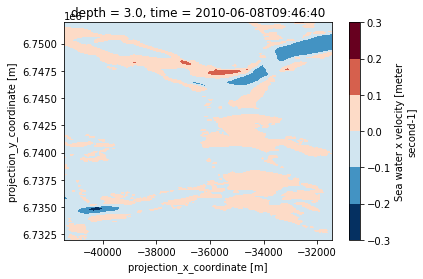

In [ ]:
res.u.isel(time=100).plot.contourf()

In [ ]:
focus=res.sel(Y=slice(6733400,6737500),X=slice(-40000,-35000))
focus_stack=focus.stack(z=['Y','X'])


In [ ]:
cru=xr.corr(focus_stack.u_pcs,focus_stack.u,dim='time')
crv=xr.corr(focus_stack.v_pcs,focus_stack.v,dim='time')


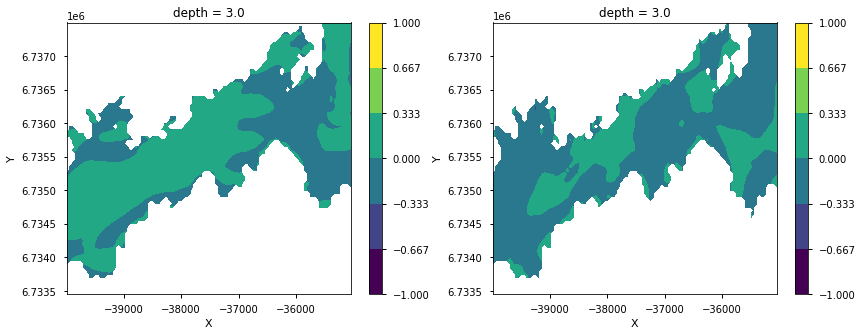

In [ ]:
style.use('seaborn-notebook')
mode=11
fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=False, sharex=True,  figsize=(14, 5))
cru.isel(mode=mode).unstack('z').plot.contourf(vmin=-1, vmax=1,ax=ax0)
crv.isel(mode=mode).unstack('z').plot.contourf(vmin=-1, vmax=1,ax=ax1)



In [ ]:
res_focus=my_svd_randomized(focus.drop(['u_eigen','u_pcs','v_pcs','u_eofs','v_eofs']),uname='u',vname='v',N=30)
res_focus

<xarray.Dataset>
Dimensions:           (Y: 82, time: 405, X: 100, mode: 30)
Coordinates:
  * Y                 (Y) float64 6.733e+06 6.733e+06 ... 6.737e+06 6.737e+06
  * X                 (X) float32 -3.999e+04 -3.994e+04 ... -3.504e+04
    depth             float32 3.0
  * time              (time) datetime64[ns] 2010-06-01 ... 2010-06-30T22:13:20
Dimensions without coordinates: mode
Data variables:
    u                 (time, Y, X) float32 0.0 0.0 0.0 ... -0.01112 -0.01352
    v                 (time, Y, X) float32 0.0 0.0 0.0 ... 0.01396 0.01355
    h                 (Y, X) float32 0.0 0.0 0.0 0.0 ... 127.2 151.3 174.5 197.2
    projection_stere  float32 9.969e+36
    land_binary_mask  (Y, X) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    u_eigen           (mode) float32 2.267e+03 575.4 122.4 ... 3.333 3.171 2.929
    u_pcs             (time, mode) float32 4.602 -0.2694 ... 0.2064 0.05262
    v_pcs             (time, mode) float32 2.275 0.2098 ... 0.122 -0.02172
    u_eofs            (mode, Y, X) float32 nan nan nan ... 0.02199 0.02705
    v_eofs            (mode, Y, X) float32 nan nan nan ... -0.03837 -0.03462
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

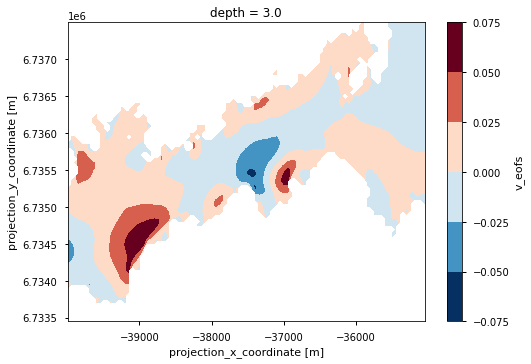

In [ ]:
res_focus.v_eofs.isel(mode=1).plot.contourf()

In [ ]:
cru_foc=xr.corr(res_focus.u_pcs,res_focus.u,dim='time')
crv_foc=xr.corr(res_focus.v_pcs,res_focus.v,dim='time')


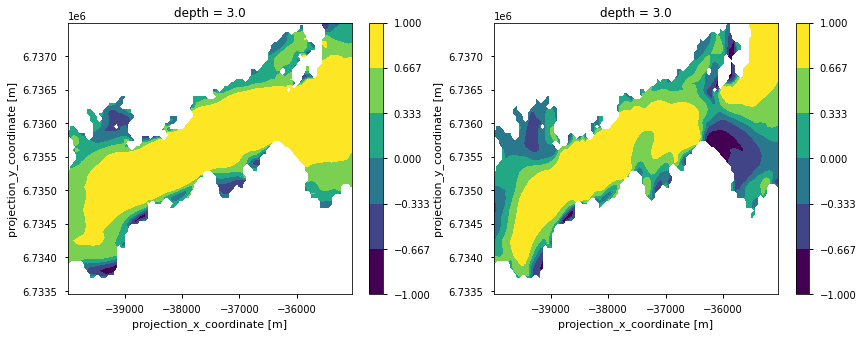

In [ ]:
style.use('seaborn-notebook')
mode=0
fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=False, sharex=True,  figsize=(14, 5))
cru_foc.isel(mode=mode).plot.contourf(vmin=-1, vmax=1,ax=ax0)
crv_foc.isel(mode=mode).plot.contourf(vmin=-1, vmax=1,ax=ax1)


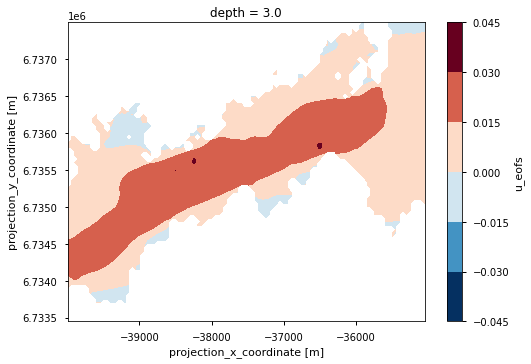

In [ ]:
focus.u_eofs.isel(mode=0).plot.contourf()

In [ ]:
res_focus

<xarray.Dataset>
Dimensions:           (Y: 82, time: 405, X: 100, mode: 30)
Coordinates:
  * Y                 (Y) float64 6.733e+06 6.733e+06 ... 6.737e+06 6.737e+06
  * X                 (X) float32 -3.999e+04 -3.994e+04 ... -3.504e+04
    depth             float32 3.0
  * time              (time) datetime64[ns] 2010-06-01 ... 2010-06-30T22:13:20
Dimensions without coordinates: mode
Data variables:
    u                 (time, Y, X) float32 0.0 0.0 0.0 ... -0.01112 -0.01352
    v                 (time, Y, X) float32 0.0 0.0 0.0 ... 0.01396 0.01355
    h                 (Y, X) float32 0.0 0.0 0.0 0.0 ... 127.2 151.3 174.5 197.2
    projection_stere  float32 9.969e+36
    land_binary_mask  (Y, X) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    u_eigen           (mode) float32 2.267e+03 575.4 122.4 ... 3.333 3.171 2.929
    u_pcs             (time, mode) float32 4.602 -0.2694 ... 0.2064 0.05262
    v_pcs             (time, mode) float32 2.275 0.2098 ... 0.122 -0.02172
    u_eofs            (mode, Y, X) float32 nan nan nan ... 0.02199 0.02705
    v_eofs            (mode, Y, X) float32 nan nan nan ... -0.03837 -0.03462
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [ ]:
mode=4
cruv=xr.corr(res_focus.u_pcs.isel(mode=mode),res_focus.v_pcs.isel(mode=mode),dim='time')
cruv#.plot.contourf(vmin=-1, vmax=1)




<xarray.DataArray ()>
array(0.84042611)
Coordinates:
    depth    float32 3.0

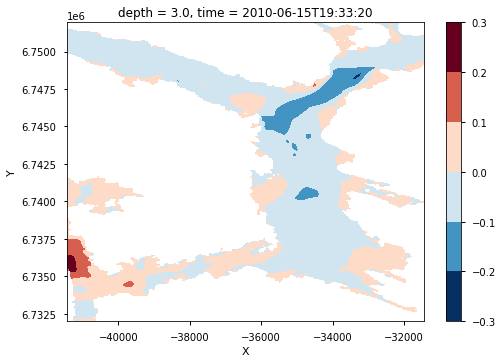

In [ ]:

res.v_eofs.dot(res.v_pcs).unstack('z').isel(time=200).plot.contourf()

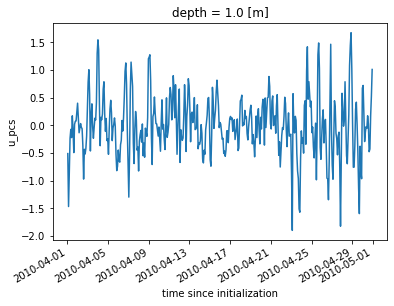

In [ ]:
res.unstack('z').direction.isel(mode=19).plot()

In [ ]:
res.Y.min()

<xarray.DataArray 'Y' ()>
array(6731999.)
Coordinates:
    depth    float32 3.0

In [ ]:
focused=res.where(((res.Y <= 6737999) & (res.X > -40000)&(res.X < -35000)),drop=True)

In [ ]:
focused_stacked=focused.stack(z=['Y','X'])

In [ ]:
work=focused_stacked.where(focused_stacked.land_binary_mask==0,drop=True)

In [ ]:
work.u.std(dim='time').min()

<xarray.DataArray 'u' ()>
array(0., dtype=float32)
Coordinates:
    depth    float32 3.0

In [ ]:
C=np.dot(((work.u-work.u.mean(dim='time'))/(1e-9+work.u.std(dim='time'))).T,
(work.u-work.u.mean(dim='time'))/(1e-9+work.u.std(dim='time')))



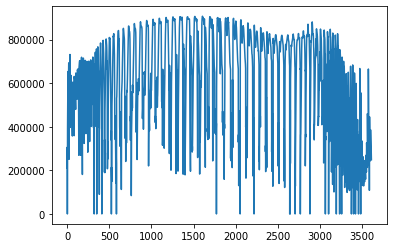

In [ ]:
plt.plot(np.sum(np.abs(C),axis=1))

In [ ]:
coor=np.where(C==np.amax(C))
coor[0]

array([2822])

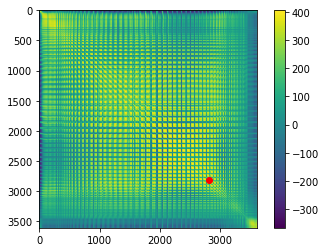

In [ ]:
plt.imshow(C)
plt.plot(coor[0],coor[1],'ro')
plt.colorbar()

Text(0.5, 1.0, 'Residue')

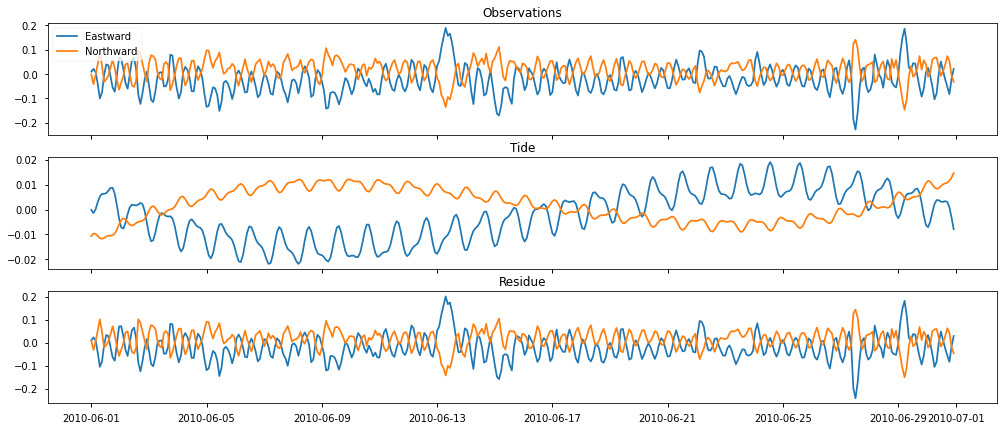

In [ ]:
from matplotlib import style

style.use('seaborn-notebook')
t=num2date(time)
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=False, sharex=True,  figsize=(17, 7))

ax0.plot(t, tmpu.u, label='Eastward')
ax0.plot(t, tmpu.v, label='Northward')
ax0.legend(numpoints=1, loc='upper left')
ax0.set_title('Observations')


ax1.plot(t, tide['u'] )
ax1.plot(t, tide['v'])
ax1.set_title('Tide')
#ax1.legend(numpoints=1, loc='upper left')

ax2.plot(t, tmpu.u-tide['u'])
ax2.plot(t, tmpu.v-tide['v'])
ax2.set_title('Residue')

In [ ]:
type(coef)
from pickle import dump

dump(coef,open('test.pkl','wb'))

utide.utilities.Bunch

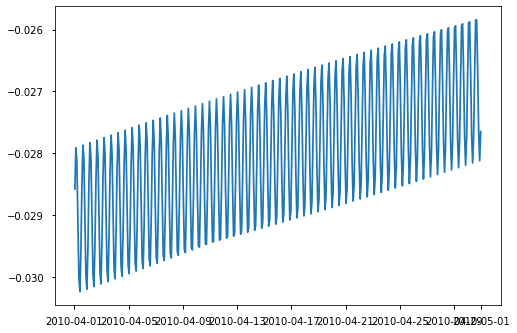

In [ ]:
plt.plot(num2date(tide.t_in),tide.v)

In [ ]:
U,L,Vh = randomized_svd(C,20)

/Users/guttorm/Documents/GitHub/FACTS/venv/lib/python3.8/site-packages/sklearn/utils/extmath.py:370: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(tmpu.u,)

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [ ]:
from pickle import dump

dump(coef,open('test.pkl','wb'))

In [ ]:
res=eofs_GA(May_stacked,neofs=None)
res['land_binary_mask']=May['land_binary_mask']
res

NotImplementedError: isna is not defined for MultiIndex

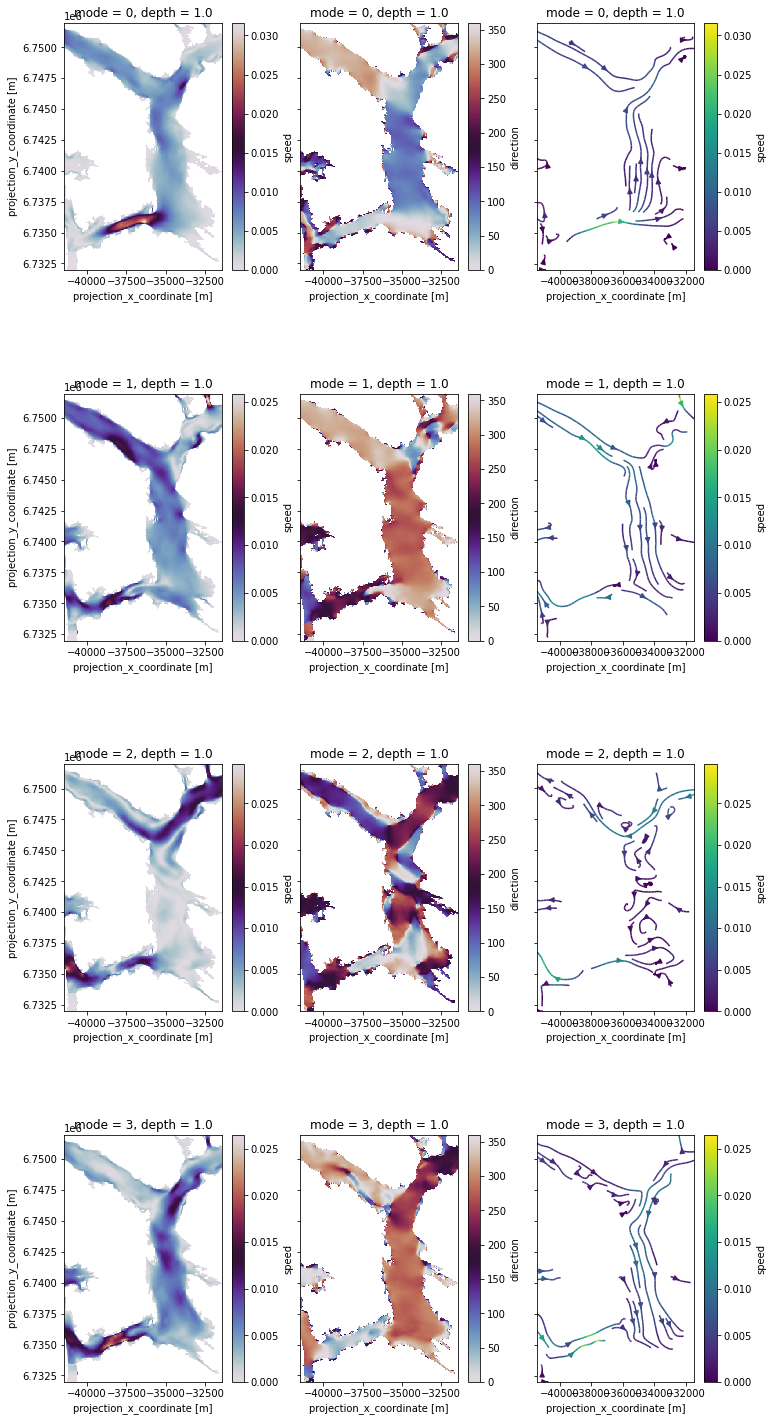

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 25))
plt.subplots_adjust(hspace=0.5)
axes=axs.ravel()
for mode in np.arange(4):
    res['speed'].where(res.land_binary_mask==0).isel(mode=mode).plot(ax=axes[3*mode],cmap='twilight')
    
    res['direction'].where(res.land_binary_mask==0).isel(mode=mode).plot(cmap='twilight',ax=axes[3*mode+1])
    res.isel(mode=mode).where(res.land_binary_mask==0).plot.streamplot(x='X',y='Y' ,u='u', v='v',hue='speed',ax=axes[3*mode+2])
    axs[mode][1].set_ylabel('')
    axs[mode][1].set_yticklabels('')
    axs[mode][2].set_ylabel('')
    axs[mode][2].set_yticklabels('')


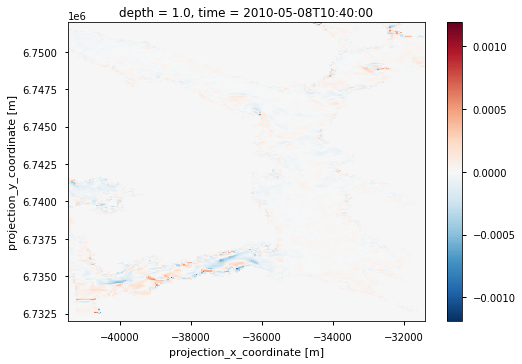

In [ ]:
(May.isel(depth=0).u.differentiate(coord='X')+May.isel(depth=0).v.differentiate(coord='Y')).isel(time=100).plot()


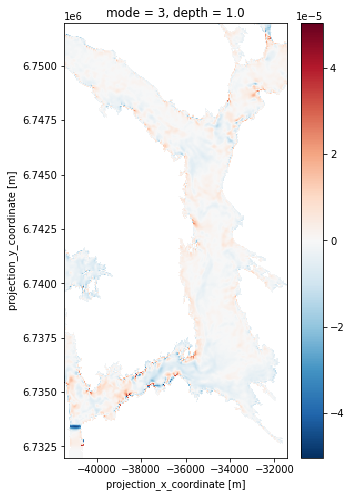

In [ ]:
tmp=res.isel(mode=3)
(tmp.u.differentiate(coord='X')+tmp.v.differentiate(coord='Y')).where(res.land_binary_mask==0).plot(figsize=(5,8))


In [ ]:
tmp[1]

<AxesSubplot:title={'center':'mode = 1, depth = 3.0'}, xlabel='projection_x_coordinate [m]', ylabel='projection_y_coordinate [m]'>

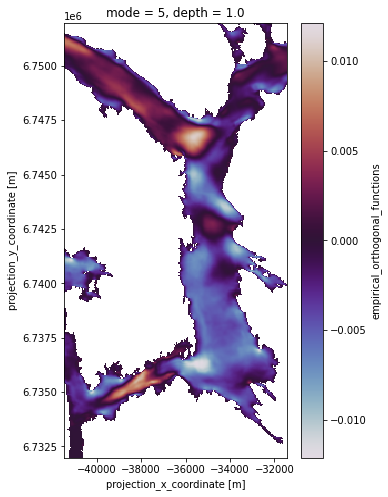

In [ ]:
res['u'].where(res.land_binary_mask==0).isel(mode=5).plot(cmap='twilight',figsize=(5,8))

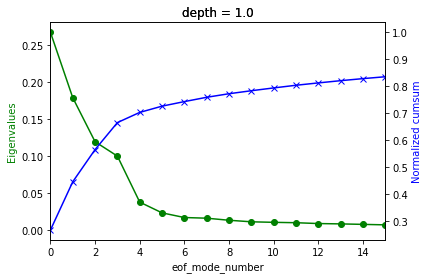

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
(res.eigenvals/res.eigenvals.sum()).plot(marker='o',color='g',ax=ax1)
(res.eigenvals.cumsum()/res.eigenvals.sum()).plot(color='b',marker='x',ax=ax2)

ax1.set_ylabel('Eigenvalues', color='g')
ax2.set_ylabel('Normalized cumsum', color='b')
plt.xlim(0,15)
plt.show()

(0.0, 5.0)

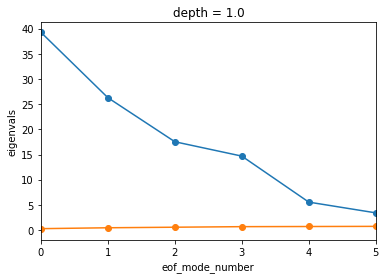

In [ ]:
res.eigenvals.plot(marker='o')
(res.eigenvals.cumsum()/res.eigenvals.sum()).plot(marker='o')
plt.xlim(0,5)

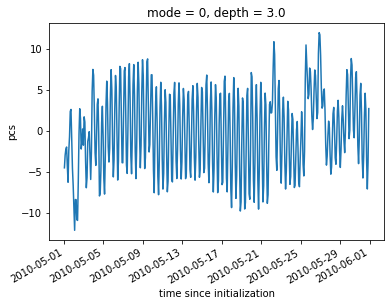

In [ ]:
mode=0
res.pcs.isel(mode=mode).plot()

TypeError: __call__() takes 1 positional argument but 2 were given

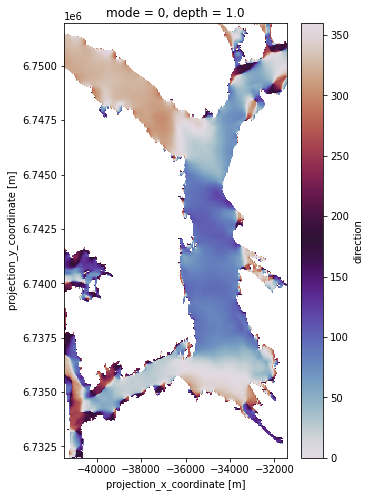

In [ ]:
mode=10
res.direction.where(res.land_binary_mask==0).isel(mode=mode).plot()

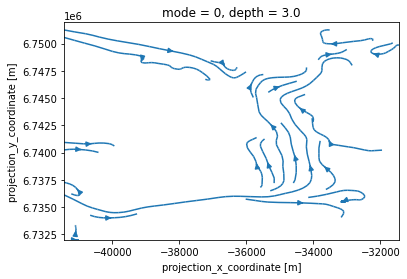

In [ ]:
res.isel(mode=mode).where(res.land_binary_mask==0).plot.streamplot(x='X',y='Y' ,u='u', v='v')

In [ ]:
help(xr.streamplot)

AttributeError: module 'xarray' has no attribute 'streamplot'

In [ ]:
mode=4
tmp=(res.isel(mode=mode).pcs*res.isel(mode=mode).eigenvals)
tmp


<xarray.DataArray (time: 418)>
array([ 2.51191559e+01,  3.43576698e+01,  2.70350609e+01, -6.90878868e+00,
       -1.74213657e+01, -1.40487537e+01, -1.97940865e+01,  1.00656357e+01,
       -3.73587632e+00, -3.60380381e-01, -2.35856175e+00, -1.31972599e+00,
        4.25410423e+01,  7.04083099e+01,  4.00344772e+01, -5.73251247e+00,
       -1.60317554e+01, -1.57020779e+01, -1.47514153e+01, -1.57096205e+01,
       -1.64089279e+01, -1.43239803e+01, -1.14165907e+01, -2.42575722e+01,
       -5.26303368e+01,  3.73313560e+01,  5.59709435e+01,  9.72277546e+00,
       -1.40220869e+00, -5.83586979e+00, -5.90118408e+00, -3.76218820e+00,
        1.64434147e+01,  3.29918137e+01, -2.25301094e+01, -2.55837078e+01,
       -1.79004879e+01, -4.56511650e+01, -1.64342537e+01,  1.59816754e+00,
        7.08576250e+00,  3.00996566e+00,  6.32103741e-01,  1.37846696e+00,
        4.23830843e+00,  7.44553423e+00,  6.48577070e+00,  1.54397130e-01,
        4.01143951e+01, -1.38502455e+01,  1.22235184e+01, -7.12136936e+00,
       -7.84985685e+00, -1.17526674e+01, -1.27301912e+01, -1.05963640e+01,
       -1.13587770e+01, -8.01495266e+00, -3.98594689e+00, -1.42811193e+01,
       -2.55945563e+00, -1.58297396e+01,  2.40459251e+01,  8.79130363e+00,
        6.99451160e+00,  1.59862947e+00, -1.75135958e+00, -1.64975250e+00,
       -6.14190054e+00, -4.94580603e+00,  9.07736897e-01, -2.43802503e-01,
       -9.99710941e+00,  3.53043228e-01, -1.88284302e+01, -5.07494259e+00,
        2.14468288e+00,  2.38385424e-01, -7.97924566e+00, -4.85249901e+00,
...
        8.04285336e+00,  1.99379654e+01,  5.24168789e-01,  1.34703531e+01,
        4.16118956e+00,  1.04785514e+00, -2.66268682e+00, -2.62183208e+01,
       -5.69773674e+01, -4.00022507e+00,  2.31581593e+01,  1.88279190e+01,
        1.02514009e+01,  5.02461100e+00,  4.92792559e+00,  8.78254700e+00,
        1.20835199e+01,  1.27113161e+01,  1.04325953e+01,  6.80696106e+00,
        4.71250010e+00,  2.04208779e+00, -4.82542574e-01, -3.20232105e+00,
       -8.65886688e+00, -1.23804083e+01, -1.14530964e+01, -5.82128048e+00,
        6.08637631e-01,  2.64530611e+00,  2.94658560e-02, -3.36639309e+00,
       -5.08620930e+00, -5.91906118e+00, -1.98346651e+00, -6.93928838e-01,
       -3.81162310e+00, -1.08745260e+01, -1.19807243e+01, -1.07903414e+01,
       -4.38737202e+00,  8.65319633e+00, -2.78511524e+00, -2.76620502e+01,
        6.76414633e+00, -6.35042000e+00,  6.65179312e-01, -4.08597660e+00,
       -2.30468065e-02, -2.65089840e-01,  8.47981071e+00, -1.30473433e+01,
       -2.62149620e+01,  1.93823552e+00,  8.58087540e+00,  7.05244827e+00,
        6.99304962e+00,  6.60602951e+00, -5.28119326e-01,  1.10472040e+01,
        1.15295839e+01,  1.00335531e+01, -9.47922826e-01,  1.35852709e+01,
        2.80311370e+00, -5.82450247e+00,  2.05472541e+00,  1.98660803e+00,
       -5.46554041e+00, -8.06682873e+00,  1.21224232e+01,  1.92555122e+01,
        6.95254230e+00, -3.38021708e+00, -7.48701620e+00, -4.07501364e+00,
       -1.37264929e+01, -4.67563725e+00], dtype=float32)
Coordinates:
    mode     int64 4
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-05-01T00:53:20 ... 2010-05-31T22:13:20

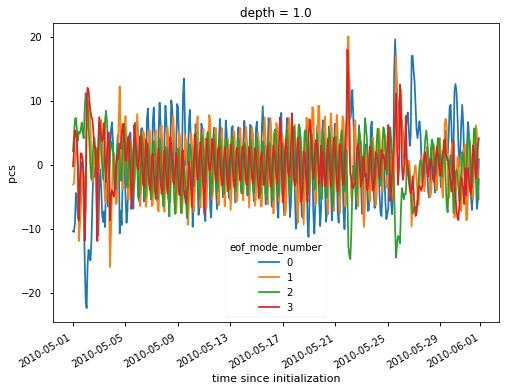

In [ ]:
res.pcs.isel(mode=[0,1,2,3]).plot.line(x='time')

In [ ]:
res

<xarray.Dataset>
Dimensions:           (mode: 10, Y: 400, X: 201, time: 1501)
Coordinates:
  * mode              (mode) int64 0 1 2 3 4 5 6 7 8 9
  * Y                 (Y) float32 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  * X                 (X) float32 -4.144e+04 -4.139e+04 ... -3.144e+04
    depth             float32 3.0
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
Data variables:
    u                 (mode, Y, X) float32 2.214e-16 4.443e-16 ... 0.0 0.0
    v                 (mode, Y, X) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    eigenvals         (mode) float32 28.59 19.41 14.78 ... 1.008 0.9224 0.8579
    land_binary_mask  (Y, X) float32 1.0 1.0 1.0 1.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    speed             (mode, Y, X) float32 2.214e-16 4.443e-16 ... 0.0 0.0
    direction         (mode, Y, X) float32 90.0 90.0 270.0 90.0 ... 0.0 0.0 0.0
    pcs               (time, mode) float32 -12.16 -2.491 -1.415 ... nan nan nan

In [ ]:
date2num(res.time)

array([14730.03703704, 14730.11111111, 14730.18518519, 14730.25925926,
       14730.33333333, 14730.40740741, 14730.48148148, 14730.55555556,
       14730.62962963, 14730.7037037 , 14730.77777778, 14730.85185185,
       14730.92592593, 14731.        , 14731.07407407, 14731.14814815,
       14731.22222222, 14731.2962963 , 14731.37037037, 14731.44444444,
       14731.51851852, 14731.59259259, 14731.66666667, 14731.74074074,
       14731.81481481, 14731.88888889, 14731.96296296, 14732.03703704,
       14732.11111111, 14732.18518519, 14732.25925926, 14732.33333333,
       14732.40740741, 14732.48148148, 14732.55555556, 14732.62962963,
       14732.7037037 , 14732.77777778, 14732.85185185, 14732.92592593,
       14733.        , 14733.07407407, 14733.14814815, 14733.22222222,
       14733.2962963 , 14733.37037037, 14733.44444444, 14733.51851852,
       14733.59259259, 14733.66666667, 14733.74074074, 14733.81481481,
       14733.88888889, 14733.96296296, 14734.03703704, 14734.11111111,
      

In [ ]:

coef = solve(date2num(res.time), y, lat=60.0, method='robust',Rayleigh_min=0.9)#, constit=['M2'])#,nodal=True, rend=True, method='robust', conf_int='linear', Rayleigh_min=0.95)

tide = reconstruct(date2num(res.time), coef)

coef.keys()

solve: matrix prep ... solution ... done.
prep/calcs ... done.


dict_keys(['name', 'aux', 'nR', 'nNR', 'nI', 'rf', 'weights', 'A', 'g', 'mean', 'slope', 'g_ci', 'A_ci', 'diagn', 'PE', 'SNR'])